# Packages

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.special import lambertw, erf
from scipy.optimize import root, minimize, minimize_scalar, basinhopping, least_squares
from scipy.integrate import solve_ivp
from scipy.stats import pearsonr

import matplotlib.cm as cm
from shapely.geometry import Polygon
from descartes import PolygonPatch

import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

fs = 7
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : fs}

# use this for all helvetica
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helvetica'] # Choose a nice font here

# use this with the example below to have more control
# from matplotlib import pyplot as plt
# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

<ipython-input-1-79a9f2fd3208>:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


# Functions

In [2]:
def lj1(T,constants1):
    sigma,eps_div_kb,M = constants1[0]
    Ts = T/eps_div_kb
    # omega from neufeld 1972
    omega = 1.16145*Ts**-0.14874+0.52487*np.exp(-0.77320*Ts)+2.16178*np.exp(-2.43787*Ts)
    return 2.6693e-6*(M*T)**0.5/sigma**2/omega

def ljm(T,constantsm):
    mum = 0
    for i in range(len(constantsm)):
        xi = constantsm[i][-1]
        Mi = constantsm[i][2]
        mui = lj1(T,[constantsm[i][:-1]])
        denom = 0
        for j in range(len(constantsm)):
            xj = constantsm[j][-1]
            Mj = constantsm[j][2]
            muj = lj1(T,[constantsm[j][:-1]])
            phiij = (1.+(mui/muj)**0.5*(Mi/Mj)**0.25)**2./(1.+Mi/Mj)**0.5/8.**0.5
            denom = denom + xj*phiij
        mum = mum + xi*mui/denom
    return mum

def lj(T,constants):
    if len(constants)==1:
        return lj1(T,constants)
    else:
        return ljm(T,constants) 

def igl1(T,p,constants1):
    M = constants1[0][2]*1e-3 #g/mol to kg/mol
    return p*M/R/T

def iglm(T,p,constantsm):
    M = 0.
    for i in range(len(constantsm)):
        M = M + constantsm[i][2]*constantsm[i][3]
    M = M*1e-3
    return p*M/R/T

def igl(T,p,constants):
    if len(constants)==1:
        return igl1(T,p,constants)
    else:
        return iglm(T,p,constants) 

def ktg1(T,p,constants1):
    M  = constants1[0][2]*1e-3
    mu = lj1(T,constants1)
    return mu/p*(np.pi*R*T/2./M)**0.5

def ktgm(T,p,constantsm):
    M = 0.
    for i in range(len(constantsm)):
        M = M + constantsm[i][2]*constantsm[i][3]
    M = M*1e-3
    mu = ljm(T,constantsm)
    return mu/p*(np.pi*R*T/2./M)**0.5

def ktg(T,p,constants):
    if len(constants)==1:
        return ktg1(T,p,constants)
    else:
        return ktgm(T,p,constants)     


In [3]:
def vdw_calc_hamaker(A,d,D):
    R = d/2.
    return A/6.*(64.*R**6./D**2./(2.*R+D)**3./(4.*R+D)**2.)

def n_calc_vT(T,n1,T1,n2,T2): # for solids
    m = (n2-n1)/(T2-T1)
    return m*(T-T1)+n1

def n_calc_vTp(T,p,n1,T1,p1,n2,T2,p2): # for gases
    # 3 points define a flat plane, n3,T3,p3 = 1,any,0
    a = (n1-1-p1*(n2-1)/p2)/(T1-p1*T2/p2)
    b = (n2-1-a*T2)/p2
    return a*T+b*p+1

def A_calc_lifshitz(T,eps_s,n_s,eps_f,n_f):
    ve = c_light/1e-7
    return 3./4.*kb*T*((eps_s-eps_f)/(eps_s+eps_f))**2.+3.*h*ve/16./2.**0.5*(n_s**2.-n_f**2.)**2./(n_s**2.+n_f**2.)**1.5

In [4]:
def u_calc_guo(z,u_s,d,nu): 
    # generalized horizontal reynolds averaged steady wall-bound flow profile, 
    # where the roughness is decided by the grain size
    # this formulation is from guo 2007
    
    zp = z*u_s/nu
    dp = d*u_s/nu
    
    kappa = 0.4
    b = 1./kappa*np.log(9.)
    c = np.exp(kappa*(16.873-b))
    
    return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)

def Cl_calc(z,u_s,d,nu): 
    # lift coefficient that depends on the gradient in wind speed, 
    # evaluated at the top and bottom of the grain
    # depends on the particle reynolds number
    # this formulation is from loth 2008b
    # it does not include rarificaiton effects
    
    u = u_calc_guo(z,u_s,d,nu)
    rep = u*d/nu
    w = (u_calc_guo(z+d/2.,u_s,d,nu)-u_calc_guo(z-d/2.,u_s,d,nu))/d
    w_s = w*d/u
    x = w_s/rep
    
    cl_saff = 12.92/np.pi*x**0.5
    j_s = 0.443*0.6765*(1.+np.tanh(2.5*np.log10(x**0.5+0.191)))*(0.667+np.tanh(6.*(x**0.5-0.32))) #written wrong in loth, also referenced to the wrong mei paper, see mei1992.pdf for correct expression used here
    cl0 = cl_saff*j_s
        
    cl1 = -w_s**(1./3.)*(0.0525+0.0575*np.tanh(5.*np.log10(rep/120.)))
    
    cl = np.empty_like(rep)
    
    cl[rep<=50.] = cl0[rep<=50.]
    cl[rep>50.]  = cl1[rep>50.]
    
    return cl

def Cd_calc(Re,Ma,gamma): 
    # drag coefficient that depends on the relative speed of the particle in the fluid
    # sensitive to the mach and reynolds (and therefore knudsen) numbers
    # this formulation is from loth 2008
    
    Kn = Ma/Re*(np.pi*gamma/2.)**0.5
    
    Cm = np.empty_like(Ma)
    Cm[(Re>45.)&(Ma<1.45)]  = 5./3.+2./3.*np.tanh(3.*np.log(Ma[(Re>45.)&(Ma<1.45)]+0.1))
    Cm[(Re>45.)&(Ma>=1.45)] = 2.044+0.2*np.exp(-1.8*np.log(Ma[(Re>45.)&(Ma>=1.45)]/1.5)**2.)
    
    Gm = np.empty_like(Ma)
    Gm[(Re>45.)&(Ma<0.89)]  = 1.-1.525*Ma[(Re>45.)&(Ma<0.89)]**4.
    Gm[(Re>45.)&(Ma>=0.89)] = 0.0002 + 0.0008*np.tanh(12.77*(Ma[(Re>45.)&(Ma>=0.89)]-2.02))
    
    Hm = np.empty_like(Ma)
    Hm[(Re>45.)] = 1.-0.258*Cm[(Re>45.)]/(1.+514.*Gm[(Re>45.)])
    
    #####
    
    s = Ma*(gamma/2.)**0.5
    Cdfmp = (1.+2.*s**2.)*np.exp(-s**2.)/s**3./np.pi**0.5+(4.*s**4.+4.*s**2.-1)*erf(s)/2./s**4.+2./3./s*np.pi**0.5
    CdfmRe = Cdfmp/(1.+(Cdfmp/1.63-1.)*(Re/45.)**0.5)
    fKn = 1./(1.+Kn*(2.514+0.8*np.exp(-0.55/Kn)))
    CdKnRe = 24./Re*(1.+0.15*Re**0.687)*fKn
    
    #####
    
    Cd = np.empty_like(Ma)
    Cd[(Re>45.)] = 24./Re[(Re>45.)]*(1.+0.15*Re[(Re>45.)]**0.687)*Hm[(Re>45.)]+0.42*Cm[(Re>45.)]/(1.+42500.*Gm[(Re>45.)]/Re[(Re>45.)]**1.16)
    Cd[(Re<=45.)] = (CdKnRe[(Re<=45.)]+Ma[(Re<=45.)]**4.*CdfmRe[(Re<=45.)])/(1.+Ma[(Re<=45.)]**4.)

    return Cd

In [5]:
def ivp(t,y,us,d,g,rho_s,rho_f,nu,T,M,gamma):
    p = y[0] 
    v = y[1]
    
    zmin = d/2.
    u = u_calc_guo(p.imag,us,d,nu)+0j # evalute flow speed at current particle height
    Cd = Cd_calc(d*np.abs(u-v)/nu,np.abs(u-v)/(gamma*R*T/M)**0.5,gamma) # evaluate drag coefficient at current absolute difference between particle and fluid speed
    Cl = Cl_calc(np.max([p.imag,zmin]),us,d,nu) # evaluate lift coefficient at current elevation
    
    dvdt = 3./4.*(Cd+Cl*1j)*rho_f/rho_s*np.abs(u-v)*(u-v)/d - (1 - rho_f/rho_s)*(0+g*1j)
    dpdt = v
    
    return dpdt,dvdt

def end(t,y,us,d,g,rho_s,rho_f,nu,T,M,gamma):
    return y[0].imag-d/2.
end.terminal  = True
end.direction = -1

def peak(t,y,us,d,g,rho_s,rho_f,nu,T,M,gamma):
    return np.angle(y[1])
peak.terminal  = False
peak.direction = -1

In [6]:
def us_calc_kok(d,g,rho_s,rho_f,nu):
    
    def get_thop(thop,vz0,g,taur):
        return (vz0/g+taur)*(1-np.exp(-thop/taur))-thop

    alphar = 0.55
    thetalift = 40*np.pi/180
    a = 0.02
    B = 0.96
    gamma = 1
    alphaej0 = 0.15
    beta = 6e-5
    
    kappa = 0.4
    z0 = d/30
    
    geff = g+6*beta/np.pi/rho_s/d**2
    
    vimp = (1-B)*(geff*d)**0.5/2/a-1/2/gamma+(1/4/gamma**2+((1-B)/2/a)**2*geff*d+(1+B)*(geff*d)**0.5/2/a/gamma)**0.5 #e13
    alphaej = alphaej0*(g/geff)**0.5
    vej = alphaej*(geff*d)**0.5/a*(1-np.exp(-vimp/40/(geff*d)**0.5)) #e15
    vlift = B*alphar*vimp*(1-1/(1+gamma*vimp)**2)+a*vimp/(geff*d)**0.5*vej #e16
    
    vx0 = vlift*np.cos(thetalift) #e17
    vz0 = vlift*np.sin(thetalift) #e17
    
    ###
    
    uit_init = 1e-1
    z_init = 2*z0*np.exp(kappa*vx0/uit_init)
    vx_init = 1e-1
    
    uit = uit_init
    z = z_init
    vx = vx_init
    
    uit_tol = 1e-5
    
    z_old = 2*z
    vx_old = 2*vx
    uit_old = 2*uit
    
    while np.abs(uit_old/uit-1)>uit_tol:
        
        ux = uit/kappa*np.log(z/z0)

        vR = np.abs(ux-vx)
        Cd = ((32/(d*vR/nu))**(2/3)+1)**1.5
        C = 3*rho_f*Cd/4/rho_s/d
        taur = 1/C/vR

        thop = root(get_thop,(vz0/g+taur)/2,args=(vz0,g,taur)).x[0] #e20

        zmax = vz0*taur-g*taur**2*np.log(1+vz0/g/taur) #e21

        vx_old = vx
        vx = ux-np.log(1+C*thop*(ux-vx0))/C/thop #e24
        
        z_old = z
        z = zmax/2
        
        uit_old = uit
        uit = kappa/np.log(z/z0)*(vx+((vimp-vx0)/C/thop)**0.5) #e8
        
#         print(ux,vR,Cd,taur,thop,z,vx,uit)
#         print(1+C*thop*(ux-vx0))
#         print(np.abs(uit_old/uit-1),np.abs(vx_old/vx-1),np.abs(z_old/z-1))
#         print('##')
    
    return uit

def ivp_claudin(t,y,us,d,g,rho_s,rho_f,nu):
    
    p = y[0] 
    v = y[1]
    
    Cinf = 1.
    s = 5.
    r = 1./10.
    kappa = 0.4

    
    Z = 1 + np.max([p.imag,d/2.])/r/d
#     Z = 1 + p.imag/r/d
    Re0 = 2.*kappa*us*r*d/nu
 
    u = us/kappa*((np.arcsinh(Re0*Z)+(1-(1+(Re0*Z)**2.)**0.5)/Re0/Z)-(np.arcsinh(Re0)+(1-(1+Re0**2.)**0.5)/Re0))+0j
    
    Cd = (Cinf**0.5+s*(nu/np.abs(u-v)/d)**0.5)**2.

    dvdt = 3./4.*Cd*rho_f/rho_s*np.abs(u-v)*(u-v)/d - (1 - rho_f/rho_s)*(0+g*1j)
    dpdt = v
    
    return dpdt,dvdt

def end_claudin(t,y,us,d,g,rho_s,rho_f,nu):
    return y[0].imag-d/2.
end_claudin.terminal  = True
end_claudin.direction = -1

def calc_e_from_traj_claudin(vup,us,d,g,rho_s,rho_f,nu,tmax):  

    a = np.pi/4.
    sol = solve_ivp(ivp_claudin,[0,tmax],[0+d/2.*1j,vup*np.exp(1j*a)],args=(us,d,g,rho_s,rho_f,nu),events=(end_claudin))
    Vdown = sol.y_events[-1][0][1]
    return vup/np.abs(Vdown)

def calc_e_absresidual_claudin(us,d,g,rho_s,rho_f,nu,tmax): # gives the magnitude of the difference between e10 and the target e10
    e = 2/3

    dm = 25e-6
    A = 15.
    vup = A*(g*d*(1+3./2.*(dm/d)**(5./3.)))**0.5

    sol = calc_e_from_traj_claudin(vup,us,d,g,rho_s,rho_f,nu,tmax)
#     print(np.abs(np.log(e)-np.log(sol)))
#     return np.abs(e-sol)
    return np.abs(np.log(e)-np.log(sol))

def get_us_claudin(d,g,rho_s,rho_f,nu,tmax,usbounds,verbose):
    usmin, usmax  = usbounds[0], usbounds[1]
    if verbose==True:
        disp = 3
    else:
        disp = 0
    sol = minimize_scalar(calc_e_absresidual_claudin,
                          bounds=(usmin,usmax),
                          args=(d,g,rho_s,rho_f,nu,tmax),
                          method='bounded',
                          options={'disp': disp})
    return sol # sol.x is us and sol.fun is the magnitude of the difference between log(e) and log(the target e) (should be ~zero)

def us_calc_claudin(d,g,rho_s,rho_f,nu,usbounds,verbose):
    usmin, usmax  = usbounds[0], usbounds[1]
    tmax = 1e+4
    
    etol   = 1e-3
    ustol  = 1e-2
    
    flag = []       
    
    sol_us = get_us_claudin(d,g,rho_s,rho_f,nu,tmax,usbounds,verbose)
    us  = sol_us.x
    
    if sol_us.fun>etol:
        flag.append('etol')
    if us>usmax*(1-ustol):
        flag.append('us at ceiling')
    if us<usmin*(1+ustol):
        flag.append('us at floor')

#     print(sol_us.fun)
    
    return us,flag

def us_calc_pahtz(d,g,rho_s,rho_f,nu,sg,E):
    
    Ga = ((rho_s/rho_f-1)*g*d**3)**0.5/nu
    s  = rho_s/rho_f
    C  = sg**0.6/E**0.2/d/((rho_s-rho_f)*g)**0.4
    
    # This function calculates the threshold after Pähtz & Durán (JGR: Earth Surface, 2018).

    # Rebound threshold Shields parameter Theta_rt = tau_rt / [(rho_p-rho_f)gd]
    # Dimensionless transport layer thickness Z = mean(z-z_r) / d
    # Dimensionless transport-layer-averaged fluid velocity U_x = mean(u_x) / sqrt[(s-1)gd]
    # Dimensionless transport-layer-averaged particle velocity V_x = mean(v_x) / sqrt[(s-1)gd]

    # Galileo number Ga = sqrt[(s-1)gd^3] / nu
    # Particle-fluid-density ratio s = rho_p / rho_f
    # Cohesion number C = d^(-1) * sigma^(3/5) * E^(-1/5) * [(rho_p-rho_f)g]^(-2/5)
    # If cohesive forces are neglected, C = 0

    # Model parameter initialization
    mub_0=0.63
    alpha=0.18
    beta=0.9
    gamma=0.79
    Z_Delta=0.7
    c_coh=0.3

    # Initialization of parameters in fluid drag law after Carmenen (JHE 2007)
    Re_c=24.
    Cd_inf=1.
    m=1.5
    
    # Function that computes the mean fluid velocity profile u_x(z)/u_t as a function of the particle Reynolds number
    # Re_d = Ga * sqrt(Theta_rt) and the vertical location z above the bed surface after Guo & Julien (2007)
    kappa=0.4
    B=np.exp(kappa*(16.873-np.log(9.)/kappa))
    
    def ux_ut_calc(Re_b,z):
        return 7.*np.arctan(Re_b*z/7.)+7./3.*np.arctan(Re_b*z/7.)**3.-0.52*np.arctan(Re_b*z/7.)**4.+np.log(1.+((Re_b*z)/B)**(1./kappa))-np.log(1.+0.3*Re_b*(1.-np.exp(-Re_b/26.)))/kappa

    svalue=s
    Gavalue=Ga
    # Computing bed friction coefficient as a function of the cohesion number
    muvalue=mub_0*(1.+1.5*(c_coh*C)**(5./3.))
    # Computing difference between fluid and particle velocity (U_x-V_x)
    Vrvalue=0.5*(Re_c/(Gavalue*Cd_inf))**(1./m)
    Vrvalue=(-Vrvalue+(Vrvalue**2.+(4.*muvalue/(3.*Cd_inf))**(1./m))**0.5)**m
    i=0
    pp=0
    sign=-1
    start=0
    
    deltaUalt = 0
    
    while 1:
        # Vary Theta_rt until all model equations are obeyed starting from Theta_rt = 1 
        p=start+sign*i*10.**pp
        Thetattry=10.**p
        # Iterative computation of Theta_rt, Z, U_x, and V_x
        Utry=Vrvalue
        while 1:
            Utryold=Utry
            Vtry=2./kappa*(1.-np.exp(-kappa**2.*gamma**2./4.*Utry**2./Thetattry))**0.5*Thetattry**0.5
            Tz=alpha**2.*Vtry**2./muvalue**2.
            Utry=Vrvalue+Vtry
            if np.abs(1.-Utry/Utryold)<0.0001:
                break
        zmtry=beta*Thetattry/muvalue+svalue*Tz

        deltaU=np.abs(1.-(Thetattry**0.5*ux_ut_calc(Thetattry**0.5*Gavalue,zmtry+Z_Delta))/Utry)
        if (i>0)&(deltaU>deltaUalt):
            if pp==-3.: # Stop calculation at high precision
                Theta_rt=Thetattryalt
                Z=zmtryalt
                U_x=Utryalt
                V_x=Vtryalt
                V_z=alpha*Vtryalt/muvalue
                break
            else:
                start=p
                sign=-sign
                pp=pp-1.
                i=0
        deltaUalt=deltaU
        Thetattryalt=Thetattry
        zmtryalt=zmtry
        Utryalt=Utry
        Vtryalt=Vtry
        i=i+1

#     return Theta_rt,Z,U_x,V_x,V_z
    uit = (Theta_rt*(s-1)*g*d)**0.5
    return uit

In [7]:
def ymt1(T,constants1):
    E_o, _, T_o, T_m = constants1
    return E_o*(2.*T_m-T)/(2.*T_m-T_o)

def ymtm(T,constantsm):
    E = []
    for i in range(len(constantsm)):
        E_o, _, T_o, T_m = constantsm[i]
        E.append(E_o*(2.*T_m-T)/(2.*T_m-T_o))
    return E

def hardness_calc_yu(E):
    a = 0.02*1e-3
    b = 4./3.
    return a*E**b

def yield_calc_evans(E,H):

    a = 0.19
    b = 1.6
    alpha = 19.7*np.pi/180

    return -H*np.log(10.)/b/lambertw(-10.**(-a/b)*H*np.log(10.)/b/np.tan(alpha)/E).real

def impact_uy_calc_johnson(E,v,Y,rho):
    Es = E/2./(1.-v**2.)
    return (26.*Y**5./Es**4./rho)**0.5


In [8]:
def calc_e10_from_e(e,thetadown):
    etheta_const = 0.82758620689
    return e*(1-etheta_const*np.sin(10.*np.pi/180.))/(1.-etheta_const*np.sin(thetadown))

def calc_e_from_e10(e10,thetadown):
    etheta_const = 0.82758620689
    return e10*(1-etheta_const*np.sin(thetadown))/(1.-etheta_const*np.sin(10.*np.pi/180.))

############################

def calc_diagnostics_from_traj(vup,us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax):
    sol = solve_ivp(ivp,[0,tmax],[0+d/2.*1j,vup*np.exp(1j*thetaup)],args=(us,d,g,rho_s,rho_f,nu,T,M,gamma),events=(peak,end))
    
    Ppeak = sol.y_events[ 0][0][0]
    Vdown = sol.y_events[-1][0][1]
    Pdown = sol.y_events[-1][0][0]

    message = sol.message
    tdown = sol.t_events[-1][0]
    zpeak = Ppeak.imag
    xdown = Pdown.real
    vdown = np.abs(Vdown)
    thetadown = np.angle(Vdown)
        
    return tdown,zpeak,xdown,vdown,thetadown,message

def calc_e_thetadown_from_traj(vup,us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax):
    sol = solve_ivp(ivp,[0,tmax],[0+d/2.*1j,vup*np.exp(1j*thetaup)],args=(us,d,g,rho_s,rho_f,nu,T,M,gamma),events=(peak,end))
    Vdown = sol.y_events[-1][0][1]
    return vup/np.abs(Vdown),np.angle(Vdown)

############################

def calc_loge10_from_traj(logvup,us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax): # finds log(e10) for a given log(vup) and us
    e,thetadown = calc_e_thetadown_from_traj(np.exp(logvup),us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax)
    e10 = calc_e10_from_e(e,-thetadown)
    return np.log(e10)

def calc_minima_loge10(us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose): # finds the minimum log(e10) for a given us
    vupmin,vupmax = vupbounds[0],vupbounds[1]
    if verbose==True:
        disp = 3
    else:
        disp = 0
        
    sol = minimize_scalar(calc_loge10_from_traj,
                          bounds=(np.log(vupmin),np.log(vupmax)),
                          args=(us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax),
                          method='bounded',
                          options={'disp': disp})
    return sol # sol.x is log(vup), sol.fun is log(e10)

def calc_minima_e10_absresidual(us,e10target,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose): # gives the magnitude of the difference between e10 and the target e10
    sol = calc_minima_loge10(us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose)
    return np.abs(e10target-np.exp(sol.fun))

def calc_us(e10target,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose): # finds the us that minimizes the difference between e10 and the target e10
    if verbose==True:
        disp = 3
    else:
        disp = 0
    sol = minimize_scalar(calc_minima_e10_absresidual,
                          bounds=(usmin,usmax),
                          args=(e10target,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose),
                          method='bounded',
                          options={'disp': disp})
    return sol # sol.x is us and sol.fun is the magnitude of the difference between e10 and the target e10 (should be ~zero)

############################

def restitution_opp(us,d,g,rho_s,rho_f,nu,T,M,gamma,vupbounds,verbose):
    vupmin,vupmax = vupbounds[0],vupbounds[1]
    tmax = 1e+4
    
    e10tol = 1e-3
    vuptol = 1e-2
    ttol   = 1e-2
    boundtol = 1e+2
    usvuptol = 1e+2
    
    flag = []
    
    if vupmin*boundtol<us:
        flag.append('vupmin << us')
    if vupmax/boundtol>us:
        flag.append('vupmax >> us')
        
    sol_vup = calc_minima_loge10(us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose)
    vup = np.exp(sol_vup.x)
    e10 = np.exp(sol_vup.fun)
    
    if vup>vupmax*(1-vuptol):
        flag.append('vup at ceiling')
    if vup<vupmin*(1+vuptol):
        flag.append('vup at floor')
        
    if vup/usvuptol>us:
        flag.append('vup >> us')
    if vup*usvuptol<us:
        flag.append('vup << us')
        
    tdown,zpeak,xdown,vdown,thetadown,message = calc_diagnostics_from_traj(vup,us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax)
    
    if tdown>tmax*(1-ttol):
        flag.append('time at ceiling')
    if 'successfully' in message:
        flag.append('no landing')
        
    return vup,e10,tdown,zpeak,xdown,vdown,thetadown,flag

############################

def impact_threshold(e10target,d,g,rho_s,rho_f,nu,T,M,gamma,vupbounds,usbounds,verbose):
    usmin, usmax  = usbounds[0], usbounds[1]
    vupmin,vupmax = vupbounds[0],vupbounds[1]
    tmax = 1e+4
    
    e10tol = 1e-3
    ustol  = 1e-2
    vuptol = 1e-2
    ttol   = 1e-2
    boundtol = 1e+2
    usvuptol = 1e+2
    
    flag = []
    
    if vupmin*boundtol<usmin:
        flag.append('vupmin << usmin')
    if vupmax/boundtol>usmax:
        flag.append('vupmax >> usmax')        
    
    sol_us = calc_us(e10target,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose)
    us  = sol_us.x
    
    if sol_us.fun>e10tol:
        flag.append('e10tol')
    if us>usmax*(1-ustol):
        flag.append('us at ceiling')
    if us<usmin*(1+ustol):
        flag.append('us at floor')
    
    sol_vup = calc_minima_loge10(us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax,vupbounds,verbose)
    vup = np.exp(sol_vup.x)
    
    if vup>vupmax*(1-vuptol):
        flag.append('vup at ceiling')
    if vup<vupmin*(1+vuptol):
        flag.append('vup at floor')
 
    if vup/usvuptol>us:
        flag.append('vup >> us')
    if vup*usvuptol<us:
        flag.append('vup << us')
        
    tdown,zpeak,xdown,vdown,thetadown,message = calc_diagnostics_from_traj(vup,us,d,g,rho_s,rho_f,nu,T,M,gamma,tmax)
    
    if tdown>tmax*(1-ttol):
        flag.append('time at ceiling')
    if 'successfully' in message:
        flag.append('no landing')
        
    return vup,us,tdown,zpeak,xdown,vdown,thetadown,flag

In [9]:
def E_CALC(d,logGa_obs,e_obs):

    amodel = 10.**(cmodel*d)
    e_pred = (emaxmodel-eminmodel)*(1-amodel/(amodel+np.exp(logGa_obs)**cmodel))+eminmodel
    return e_obs-e_pred

def model_e(Ga):
    amodel = 10.**(cmodel*fitD)
    return (emaxmodel-eminmodel)*(1-amodel/(amodel+Ga**cmodel))+eminmodel

# Constants

In [10]:
R  = 8.314462
kb = 1.381e-23
h  = 6.626e-34
kappa = 0.412
c_light = 299792458
d0 = 0.165e-9

In [11]:
# sigma, eps_div_kb, M, x

lj_constants_ea = [[3.617, 97. ,28.964]] # Air
lj_constants_ma = [[3.996,190. ,44.01 ,0.953], # CO2
                   [3.667, 99.8,28.013,0.027], # N2
                   [3.432,122.4,39.948,0.016]] # Ar
lj_constants_ti = [[3.617, 99.8,28.013,0.953], # N2
                   [3.78 ,154. ,16.04 ,0.047]] # CH4
lj_constants_ve = [[3.996,190. ,44.01 ,0.965], # CO2
                   [3.617, 99.8,28.013,0.035]] # N2
lj_constants_pl = [[3.617, 99.8,28.013]] # N2
lj_constants_tr = [[3.617, 99.8,28.013]] # N2

gamma_ea = 1.40
gamma_ma = 1.31
gamma_ti = 1.47
gamma_ve = 1.235
gamma_pl = 1.47
gamma_tr = 1.47

g_ea = 9.81
g_ma = 3.73
g_ti = 1.36
g_ve = 8.88
g_pl = 0.62
g_tr = 0.78

p_ea = [   98200. ,  104900. ]
p_ma = [     500. ,     750. ]
p_ti = [  149526. ,  149759. ]
p_ve = [ 4500000. ,11000000. ]
p_pl = [       1. ,       1.1]
p_tr = [       1.5,       1.9]

T_ea = [270.,320.]
T_ma = [143.,265.]
T_ti = [ 90., 94.]
T_ve = [650.,755.]
T_pl = [ 37., 55.]
T_tr = [ 43., 53.]

nu_reported_ea = [1.5e-5,3.2e-5]
nu_reported_ma = [5.4e-4,6.0e-4,1.0e-3]
nu_reported_ti = [1.235e-6]
nu_reported_ve = [2.50e-7,4.85e-7]
nu_reported_pl = [2e-2]
nu_reported_tr = [4.5e-2]

rho_f_reported_ea = [1.2e+0]
rho_f_reported_ma = [1.5e-2,2.0e-2]
rho_f_reported_ti = [5.1e+0]
rho_f_reported_ve = [3.6e+1,7.4e+1]
rho_f_reported_pl = [9.1e-5]
rho_f_reported_tr = [1.4e-4]

rho_s_ea = [2650.,2380.] # SiO2, CaSO4.2*H2O
rho_s_ma = [3000.,2650.] # Basalt, SiO2
rho_s_ti = [1400., 400., 950.] # Tholin, Tholin eff, H2O
rho_s_ve = [3000.,2650.] # Basalt, various
rho_s_pl = [ 470., 940.] # CH4, N2 
rho_s_tr = [1400., 400., 470., 940.] # Tholin, Tholin eff, CH4, N2

# E(T_o), v(T_o), T_o, T_m
solidmech_ea = [[1.075e+11,0.2 ,300. ,1700.  ], # SiO2
                [3.744e+10,0.3 ,300. , 419.  ]] # CaSO4.2*H2O
solidmech_ma = [[9.231e+10,0.2 ,300. ,1333.  ], # Basalt
                [1.075e+11,0.2 ,300. ,1700.  ]] # SiO2
solidmech_ti = [[1.038e+10,0.35,300. , 350.  ], # Tholin
                [1.038e+10,0.35,300. , 350.  ], # Tholin eff
                [1.000e+10,0.31, 77. , 273.  ]] # H2O
solidmech_ve = [[9.231e+10,0.2 ,300. ,1333.  ], # Basalt
                [1.075e+11,0.2 ,300. ,1700.  ]] # various (assume Quartz)
solidmech_pl = [[3.312e+10,0.26, 20.5,  90.67], # CH4
                [1.747e+09,0.3 , 37. ,  64.  ]] # N2
solidmech_tr = [[1.038e+10,0.35,300. , 350.  ], # Tholin
                [1.038e+10,0.35,300. , 350.  ], # Tholin eff
                [3.312e+10,0.26, 20.5,  90.67], # CH4
                [1.747e+09,0.3 , 37. ,  64.  ]] # N2

In [12]:
# VAN DER WAALS STUFF

# try get values for n at different temps and pressures close to planet conditions
# at reference wavelengths of 
# 589.29 nm (visible) i.e. 6e-7 m wavelength, 5e+14 1/s frequency
# 100 nm (UV) i.e. 1e-7 m wavelength, 3e+15 1/s frequency

# SOLIDS
# n, wavelength (m), temperature (K)
ns_CH4_1  = [1.3310,6.328e-7,30] #https://doi.org/10.1364/AO.33.008306
ns_CH4_2  = [1.3210,6.328e-7,90] #https://doi.org/10.1364/AO.33.008306
ns_SiO2_1 = [1.4575,6.328e-7,300] #https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20070018851.pdf
ns_SiO2_2 = [1.4566,6.328e-7,180] #https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20070018851.pdf
ns_Gyps_1 = [1.5218,5.730e-7,273.15+12] #https://www.jstor.org/stable/92960
ns_Gyps_2 = [1.5190,5.730e-7,273.15+105] #https://www.jstor.org/stable/92960
ns_Basa_1 = [1.5690,5.900e-7,273.15+23] #https://doi.org/10.1007/s002690050085
ns_Basa_2 = [1.5691,5.900e-7,273.15+2500] # can't find anything so assuming no T dependence :(
ns_H2O_1  = [1.2603,6.328e-7,90] #https://doi.org/10.3847/1538-4357/ab0d89
ns_H2O_2  = [1.2464,6.328e-7,70] #https://doi.org/10.3847/1538-4357/ab0d89
ns_N2_1   = [1.22,6.328e-7,22] #https://doi.org/10.1016/j.pss.2008.07.015
ns_N2_2   = [1.20,6.328e-7,10] #https://doi.org/10.1016/j.pss.2008.07.015
# static relative permittivity i.e. the dialectric constant at frequency = 0
eps_CH4   = 1.725 #80K # https://doi.org/10.1063/1.1724850
eps_SiO2   = 3.8 #isrealachvilli
eps_Gyps   = 5.7 #file:///home/andrew/Downloads/pdfhall.com_265-dielectric-properties-of-materials_5b397fa5097c47f3488b4580.pdf
eps_Basa   = 3.8 #going to take as SiO2 because there's so many different basalts
eps_H2O    = 250. #at 90K #K. F. Young and H. P. R. Frederikse (1973) Compilation of the Static Dielectric Constant of Inorganic Solids, J. Phys. Chem. Ref. Data, 2(2), 313–410.
eps_N2     = 1.462 #at 47.9K #https://www.dwc.knaw.nl/DL/publications/PU00015389.pdf

# FLUIDS
# material, n, wavelength (m), temperature (K), pressure (Pa)
nf_air_1 = [1.00027180,6.328e-7,273.15+20,101325] #https://doi.org/10.1364/AO.35.001566
nf_air_2 = [1.00022554,6.328e-7,273.15+80,101325] #https://doi.org/10.1364/AO.35.001566
nf_CO2_1 = [1.00005440,6.328e-7,273.15+15, 13170] #https://doi.org/10.1021/je980133o
nf_CO2_2 = [1.00039706,6.328e-7,273.15+50,105360] #https://doi.org/10.1021/je980133o
nf_N2_1  = [1.00003581,6.328e-7,273.15+15, 13170] #https://doi.org/10.1021/je980133o
nf_N2_2  = [1.00026470,6.328e-7,273.15+50,105360] #https://doi.org/10.1021/je980133o
# static relative permittivity i.e. the dialectric constant at frequency = 0
# assume 1 for all
epf_air = 1
epf_CO2 = 1
epf_N2  = 1

vdw_constants_ea = [[eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_air,nf_air_1[0],nf_air_1[2],nf_air_1[3],nf_air_2[0],nf_air_2[2],nf_air_2[3]],
                    [eps_Gyps,ns_Gyps_1[0],ns_Gyps_1[2],ns_Gyps_2[0],ns_Gyps_2[2],epf_air,nf_air_1[0],nf_air_1[2],nf_air_1[3],nf_air_2[0],nf_air_2[2],nf_air_2[3]]]
vdw_constants_ma = [[eps_Basa,ns_Basa_1[0],ns_Basa_1[2],ns_Basa_2[0],ns_Basa_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]],
                    [eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]]]
vdw_constants_ti = [[np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_H2O,ns_H2O_1[0],ns_H2O_1[2],ns_H2O_2[0],ns_H2O_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]
vdw_constants_ve = [[eps_Basa,ns_Basa_1[0],ns_Basa_1[2],ns_Basa_2[0],ns_Basa_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]],
                    [eps_SiO2,ns_SiO2_1[0],ns_SiO2_1[2],ns_SiO2_2[0],ns_SiO2_2[2],epf_CO2,nf_CO2_1[0],nf_CO2_1[2],nf_CO2_1[3],nf_CO2_2[0],nf_CO2_2[2],nf_CO2_2[3]]]
vdw_constants_pl = [[eps_CH4,ns_CH4_1[0],ns_CH4_1[2],ns_CH4_2[0],ns_CH4_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_N2,ns_N2_1[0],ns_N2_1[2],ns_N2_2[0],ns_N2_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]
vdw_constants_tr = [[np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [np.nan,np.nan,np.nan,np.nan,np.nan,epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_CH4,ns_CH4_1[0],ns_CH4_1[2],ns_CH4_2[0],ns_CH4_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]],
                    [eps_N2,ns_N2_1[0],ns_N2_1[2],ns_N2_2[0],ns_N2_2[2],epf_N2,nf_N2_1[0],nf_N2_1[2],nf_N2_1[3],nf_N2_2[0],nf_N2_2[2],nf_N2_2[3]]]

Fad_tholin = np.mean(np.asarray([2723,2571,2568,2561,2556,2554,2204,2267,2205,2141,2160]))*1e-9 # values reported for 1% RH tests by Yu 2017, room temperature
r_tholin = 20e-6/2. # a flat surface and a 20 micron spherical tip
A_tholin = 6.*Fad_tholin*d0**2.*(2.*r_tholin+d0)**3.*(4.*r_tholin+d0)**2./64./r_tholin**6. # hamaker constant for tholins in ambient room air

In [13]:
name = ['Earth',
        'Mars',
        'Titan',
        'Venus',
        'Pluto',
        'Triton']

sediment = [['Quartz','Gypsum'],
            ['Basalt','Quartz'],
            ['Tholin (Dense)','Tholin (Light)','Water Ice'],
            ['Basalt','Quartz'],
            ['Methane Ice','Nitrogen Ice'],
            ['Tholin (Dense)','Tholin (Light)','Methane Ice','Nitrogen Ice']]

color = ['purple',
         'red',
         'blue',
         'gold',
         'orange',
         'green']

marker = [['o','P'],
          ['v','o'],
          ['D','s','p'],
          ['v','o'],
          ['X','^'],
          ['D','s','X','^']]

classify_sediments =  [['Quartz','o'],
                    ['Gypsum','P'],
                    ['Basalt','v'],
                    ['Tholin (Dense)','D'],
                    ['Tholin (Light)','s'],
                    ['Water Ice','p'],
                    ['Methane Ice','X'],
                    ['Nitrogen Ice','^']]

lj_constants = [lj_constants_ea,
                lj_constants_ma,
                lj_constants_ti,
                lj_constants_ve,
                lj_constants_pl,
                lj_constants_tr]

M = np.asarray([28.964,44.01*0.953+28.013*0.027+39.948*0.016,28.013*0.953+16.04*0.047,44.01*0.965+28.013*0.035,28.013,28.013])*1e-3 #g/mol to kg/mol

gamma = [gamma_ea,
         gamma_ma,
         gamma_ti,
         gamma_ve,
         gamma_pl,
         gamma_tr]

g = [g_ea,
     g_ma,
     g_ti,
     g_ve,
     g_pl,
     g_tr]

p = [p_ea,
     p_ma,
     p_ti,
     p_ve,
     p_pl,
     p_tr]

T = [T_ea,
     T_ma,
     T_ti,
     T_ve,
     T_pl,
     T_tr]

nu_reported = [nu_reported_ea,
               nu_reported_ma,
               nu_reported_ti,
               nu_reported_ve,
               nu_reported_pl,
               nu_reported_tr]

rho_f_reported = [rho_f_reported_ea,
                  rho_f_reported_ma,
                  rho_f_reported_ti,
                  rho_f_reported_ve,
                  rho_f_reported_pl,
                  rho_f_reported_tr]

rho_s = [rho_s_ea,
         rho_s_ma,
         rho_s_ti,
         rho_s_ve,
         rho_s_pl,
         rho_s_tr]

solidmech = [solidmech_ea,
             solidmech_ma,
             solidmech_ti,
             solidmech_ve,
             solidmech_pl,
             solidmech_tr]

vdw_constants = [vdw_constants_ea,
                vdw_constants_ma,
                vdw_constants_ti,
                vdw_constants_ve,
                vdw_constants_pl,
                vdw_constants_tr]

In [14]:
Nn = 6
NT = 2
Np = 2

E = []
Y = []
vY = []

A = []

T_x   = np.empty((Nn,NT))
p_x   = np.empty((Nn,   Np))
nu    = np.empty((Nn,NT,Np))
rho_f = np.empty((Nn,NT,Np))
lambd = np.empty((Nn,NT,Np))
c     = np.empty((Nn,NT,Np))

for i in range(Nn):
    
    T_x[i] = np.linspace(T[i][0],T[i][1],NT)
    p_x[i] = np.linspace(p[i][0],p[i][1],Np)
    
    TempE = []
    TempY = []
    TempvY = []
    for j in range(len(solidmech[i])):
        tempE = np.empty(NT)
        tempY = np.empty(NT)
        tempvY = np.empty(NT)
        for k in range(NT):
            tempE[k] = ymt1(T_x[i][k],solidmech[i][j])
            tempY[k] = yield_calc_evans(tempE[k],hardness_calc_yu(tempE[k]))
            if sediment[i][j]=='Tholin (Light)':
                tempY[k] = tempY[k]*400/1400
            tempvY[k] = impact_uy_calc_johnson(tempE[k],solidmech[i][j][1],tempY[k],rho_s[i][j])
        print('%s %s: E = %.2e Pa, Y = %.2e Pa, vY = %.2e m/s'%(name[i],sediment[i][j],np.mean(tempE),np.mean(tempY),np.mean(tempvY)))
        TempE.append(tempE)
        TempY.append(tempY)
        TempvY.append(tempvY)
    E.append(TempE)
    Y.append(TempY)
    vY.append(TempvY)
    
    for j in range(NT):
        for k in range(Np):
            nu[i,j,k]    = lj(T_x[i][j],lj_constants[i])/igl(T_x[i][j],p_x[i][k],lj_constants[i])
            rho_f[i,j,k] = igl(T_x[i][j],p_x[i][k],lj_constants[i])
            lambd[i,j,k] = ktg(T_x[i][j],p_x[i][k],lj_constants[i])
            c[i,j,k]     = (gamma[i]*p_x[i][k]/igl(T_x[i][j],p_x[i][k],lj_constants[i]))**0.5
            
    TEMPA = []
    for j in range(len(sediment[i])):
        tempA = np.empty((NT,Np))
        for k in range(NT):
            for l in range(Np):        
                if 'Tholin' in sediment[i][j]:
                    tempA[k,l] = A_tholin
                else:
                    tempA[k,l] = A_calc_lifshitz(T_x[i][k],
                                            vdw_constants[i][j][0],
                                            n_calc_vT(T_x[i][k],*vdw_constants[i][j][1:5]),
                                            vdw_constants[i][j][5],
                                            n_calc_vTp(T_x[i][k],p_x[i][l],*vdw_constants[i][j][6:]))
        TEMPA.append(tempA)
    A.append(TEMPA)

Earth Quartz: E = 1.08e+11 Pa, Y = 3.19e+10 Pa, vY = 5.74e+03 m/s
Earth Gypsum: E = 3.78e+10 Pa, Y = 1.36e+10 Pa, vY = 5.23e+03 m/s
Mars Basalt: E = 9.61e+10 Pa, Y = 2.94e+10 Pa, vY = 5.50e+03 m/s
Mars Quartz: E = 1.11e+11 Pa, Y = 3.26e+10 Pa, vY = 5.70e+03 m/s
Titan Tholin (Dense): E = 1.58e+10 Pa, Y = 6.17e+09 Pa, vY = 5.05e+03 m/s
Titan Tholin (Light): E = 1.58e+10 Pa, Y = 1.76e+09 Pa, vY = 4.12e+02 m/s
Titan Water Ice: E = 9.68e+09 Pa, Y = 3.91e+09 Pa, vY = 5.53e+03 m/s
Venus Basalt: E = 7.66e+10 Pa, Y = 2.47e+10 Pa, vY = 5.59e+03 m/s
Venus Quartz: E = 9.35e+10 Pa, Y = 2.88e+10 Pa, vY = 5.87e+03 m/s
Pluto Methane Ice: E = 2.79e+10 Pa, Y = 1.04e+10 Pa, vY = 1.15e+04 m/s
Pluto Nitrogen Ice: E = 1.57e+09 Pa, Y = 6.86e+08 Pa, vY = 2.74e+03 m/s
Triton Tholin (Dense): E = 1.69e+10 Pa, Y = 6.59e+09 Pa, vY = 5.16e+03 m/s
Triton Tholin (Light): E = 1.69e+10 Pa, Y = 1.88e+09 Pa, vY = 4.21e+02 m/s
Triton Methane Ice: E = 2.75e+10 Pa, Y = 1.02e+10 Pa, vY = 1.15e+04 m/s
Triton Nitrogen Ice: E =

In [15]:
for i in range(Nn):
    for j in range(len(sediment[i])):
        print(np.mean(A[i][j])/12./np.pi/d0**2.*1e+3,(np.max(A[i][j])-np.min(A[i][j]))/12./np.pi/d0**2.*1e+3, sediment[i][j])

59.66783196135493 0.2739894707144565 Quartz
74.90075747224903 0.10973225680371239 Gypsum
85.82451625962385 0.41973205104177536 Basalt
59.274035664523964 0.6218381228788594 Quartz
76.71521412145145 0.0 Tholin (Dense)
76.71521412145145 0.0 Tholin (Light)
22.392544511521404 0.4624255935319058 Water Ice
78.97834821845709 7.388912892148489 Basalt
54.44372914299894 6.537972801390937 Quartz
32.65904532470092 0.5263738225600955 Methane Ice
21.35155705787739 4.5495137432765285 Nitrogen Ice
76.71521412145145 0.0 Tholin (Dense)
76.71521412145145 0.0 Tholin (Light)
32.60028266138693 0.2922177923883342 Methane Ice
21.824885002989625 2.5525862620449584 Nitrogen Ice


# Other People's Predictions

In [16]:
Nd = 30
d = np.logspace(-5,-2,Nd)

In [17]:
us_kok = []

for i in range(Nn):
    us_kokTEMP = []
    for j in range(len(sediment[i])):
        us_koktemp = np.empty(Nd)
        for k in range(Nd):
            us_koktemp[k] = us_calc_kok(d[k],g[i],rho_s[i][j],np.mean(rho_f[i]),np.mean(nu[i]))
            print(i,j,k)
        us_kokTEMP.append(us_koktemp)
    us_kok.append(us_kokTEMP)
with open('impact_threshold_kok.pkl', 'wb') as tempfile:
    pickle.dump((us_kok,d), tempfile)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 0 10
1 0 11
1 0 12
1 0 13
1 0 14
1 0 15
1 0 16
1 0 17
1 0 18
1 0 19
1 0 20
1 0 21
1 0 22
1 0 23
1 0 24
1 0 25
1 0 26
1 0 27
1 0 28
1 0 29
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29


In [18]:
us_pahtz = []

for i in range(Nn):
    us_pahtzTEMP = []
    for j in range(len(sediment[i])):
        us_pahtztemp = np.empty(Nd)
        for k in range(Nd):
            us_pahtztemp[k] = us_calc_pahtz(d[k],g[i],rho_s[i][j],np.mean(rho_f[i]),np.mean(nu[i]),np.mean(A[i][j])/12./np.pi/d0**2.,np.mean(E[i][j]))
            print(i,j,k)
        us_pahtzTEMP.append(us_pahtztemp)
    us_pahtz.append(us_pahtzTEMP)
with open('impact_threshold_pahtz.pkl', 'wb') as tempfile:
    pickle.dump((us_pahtz,d), tempfile)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 0 10
1 0 11
1 0 12
1 0 13
1 0 14
1 0 15
1 0 16
1 0 17
1 0 18
1 0 19
1 0 20
1 0 21
1 0 22
1 0 23
1 0 24
1 0 25
1 0 26
1 0 27
1 0 28
1 0 29
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29


In [19]:
us_claudin = []

usbounds_temp = [1e-2,1e+2]

verbose=False

for i in range(Nn):
    us_claudinTEMP = []
    for j in range(len(sediment[i])):
        us_claudintemp = np.empty(Nd)
        for k in range(Nd):
            us_claudintemp[k],flag = us_calc_claudin(d[k],g[i],rho_s[i][j],np.mean(rho_f[i]),np.mean(nu[i]),usbounds_temp,verbose)
            print(i,j,k,flag)
        us_claudinTEMP.append(us_claudintemp)
    us_claudin.append(us_claudinTEMP)
with open('impact_threshold_claudin.pkl', 'wb') as tempfile:
    pickle.dump((us_claudin,d), tempfile)

0 0 0 []
0 0 1 []
0 0 2 []
0 0 3 []
0 0 4 []
0 0 5 []
0 0 6 []
0 0 7 []
0 0 8 []
0 0 9 []
0 0 10 []
0 0 11 []
0 0 12 []
0 0 13 []
0 0 14 []
0 0 15 []
0 0 16 []
0 0 17 []
0 0 18 []
0 0 19 []
0 0 20 []
0 0 21 []
0 0 22 []
0 0 23 []
0 0 24 []
0 0 25 []
0 0 26 []
0 0 27 []
0 0 28 []
0 0 29 []
0 1 0 ['etol']
0 1 1 []
0 1 2 []
0 1 3 []
0 1 4 []
0 1 5 []
0 1 6 []
0 1 7 []
0 1 8 []
0 1 9 []
0 1 10 []
0 1 11 []
0 1 12 []
0 1 13 []
0 1 14 []
0 1 15 []
0 1 16 []
0 1 17 []
0 1 18 []
0 1 19 []
0 1 20 []
0 1 21 []
0 1 22 []
0 1 23 []
0 1 24 []
0 1 25 []
0 1 26 []
0 1 27 []
0 1 28 []
0 1 29 []
1 0 0 []
1 0 1 ['etol']
1 0 2 []
1 0 3 []
1 0 4 []
1 0 5 []
1 0 6 []
1 0 7 []
1 0 8 []
1 0 9 []
1 0 10 []
1 0 11 []
1 0 12 []
1 0 13 []
1 0 14 []
1 0 15 []
1 0 16 []
1 0 17 []
1 0 18 []
1 0 19 []
1 0 20 []
1 0 21 []
1 0 22 []
1 0 23 []
1 0 24 []
1 0 25 []
1 0 26 []
1 0 27 []
1 0 28 []
1 0 29 []
1 1 0 []
1 1 1 []
1 1 2 []
1 1 3 []
1 1 4 []
1 1 5 []
1 1 6 []
1 1 7 []
1 1 8 []
1 1 9 []
1 1 10 []
1 1 11 []
1 1 12 [

In [20]:
with open('impact_threshold_kok.pkl', 'rb') as tempfile:
    us_kok,d = pickle.load(tempfile)
    
with open('impact_threshold_pahtz.pkl', 'rb') as tempfile:
    us_pahtz,d = pickle.load(tempfile)
    
with open('impact_threshold_claudin.pkl', 'rb') as tempfile:
    us_claudin,d = pickle.load(tempfile)

In [21]:
tempdata = pd.read_csv('SI_table4.csv',header=1)
us_opp   = np.asarray(tempdata.iloc[:,1])
d_opp     = np.asarray(tempdata.iloc[:,0])
rho_f_opp = np.asarray(tempdata.iloc[:,4])
rho_s_opp = np.asarray(tempdata.iloc[:,5])
nu_opp    = np.asarray(tempdata.iloc[:,7])
T_opp     = np.asarray(tempdata.iloc[:,8])
g_opp     = np.asarray(tempdata.iloc[:,9])
gamma_opp = np.asarray(tempdata.iloc[:,10])
M_opp     = np.asarray(tempdata.iloc[:,11])*1e-3 #g/mol to kg/mol
ref_opp   = np.asarray(tempdata.iloc[:,18])
reffull_opp = np.asarray(tempdata.iloc[:,19])

s_opp = rho_s_opp/rho_f_opp
Ga_opp = (d_opp**3.*g_opp*(rho_s_opp/rho_f_opp-1.))**0.5/nu_opp
St_like_opp = (rho_s_opp/rho_f_opp)**0.5*Ga_opp
Sh_opp = us_opp**2./d_opp/g_opp/(s_opp-1.)

In [22]:
ofnoterefs = ['martin2017','li2014','andreotti2020','burr2020']
uniquerefs = np.unique(ref_opp)
uniquerefsfull = np.unique(reffull_opp)
colors  = ['r','g','b','c','m','y','k']
markers = ['o','s','D']
Nopp = len(us_opp)

In [23]:
vup_opp = np.empty(Nopp)
e10_opp = np.empty(Nopp)
tdown_opp = np.empty(Nopp)
zpeak_opp = np.empty(Nopp)
xdown_opp = np.empty(Nopp)
vdown_opp = np.empty(Nopp)
thetadown_opp = np.empty(Nopp)
flag_opp = []

verbose = False
thetaup = 50*np.pi/180.

for i in range(Nopp):
    vupbounds = [us_opp[i]/10,us_opp[i]*100]
    vup_opp[i],e10_opp[i],tdown_opp[i],zpeak_opp[i],xdown_opp[i],vdown_opp[i],thetadown_opp[i],flag = restitution_opp(us_opp[i],d_opp[i],g_opp[i],rho_s_opp[i],rho_f_opp[i],nu_opp[i],T_opp[i],M_opp[i],gamma_opp[i],vupbounds,verbose)
    flag_opp.append(flag)
    print(i,e10_opp[i],flag)
    
St_opp = vdown_opp*d_opp*rho_s_opp/9/(nu_opp*rho_f_opp)

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)
/home/andle/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


0 0.47231467140257 []
1 0.6168258255894621 []
2 0.6540267952692111 []
3 0.7425770117136307 []
4 0.33897908405225224 []
5 0.257486425862048 []
6 0.4460001478023274 []
7 0.469359180701209 []
8 0.37815476097875667 []
9 0.5082176054308114 ['vupmax >> us']
10 0.5556863666990416 []
11 0.634731564919837 []
12 0.6524966811173141 []
13 0.8106551482191621 []
14 1.0001252646789052 []
15 0.3205885640294596 []
16 0.3364152013626149 []
17 0.35500644066788656 []
18 0.39670738516421145 []
19 0.447285636030901 []
20 0.5335455071039321 []
21 0.5525194971609184 []
22 0.4752103651879637 []
23 0.15425817910565243 []
24 0.2202283338144725 []
25 0.22133655517236003 []
26 0.22059663149007186 []
27 0.19014133908204467 ['vupmax >> us']
28 0.1895772278010659 []
29 0.16007113296291905 []
30 0.3267502659876977 ['vupmax >> us']
31 0.3250424895554336 ['vupmax >> us']
32 0.31339170779888553 []
33 0.31155988828439846 []
34 0.2609422781002108 []
35 0.26158300259379885 []
36 0.21200621899876992 []
37 0.2634881503937036 

In [24]:
tempdata = pd.read_csv('SI_table5.csv',header=1)
e_rest = np.asarray(tempdata.iloc[:,0])
d_rest = np.asarray(tempdata.iloc[:,1])
thetadown_rest = np.asarray(tempdata.iloc[:,2])
# thetaup_rest = np.asarray(tempdata.iloc[:,3])
vdown_rest = np.asarray(tempdata.iloc[:,3])
vup_rest = vdown_rest*e_rest
u_s_obs_rest = np.asarray(tempdata.iloc[:,4])
u_s_thr_rest = np.asarray(tempdata.iloc[:,5])
rho_f_rest = np.asarray(tempdata.iloc[:,7])
rho_s_rest = np.asarray(tempdata.iloc[:,8])
# A_rest = np.asarray(tempdata.iloc[:,12])
nu_rest = np.asarray(tempdata.iloc[:,10])
T_rest = np.asarray(tempdata.iloc[:,11])
g_rest = np.asarray(tempdata.iloc[:,12])
gamma_rest = np.asarray(tempdata.iloc[:,13])
M_rest = np.asarray(tempdata.iloc[:,14])*1e-3 #g/mol to kg/mol
ref_rest = np.asarray(tempdata.iloc[:,18])
reffull_rest = np.asarray(tempdata.iloc[:,19])

u_s_obs_rest[u_s_obs_rest=='All'] = np.nan
u_s_obs_rest = np.asarray(u_s_obs_rest,dtype='float')

s_rest = rho_s_rest/rho_f_rest
Ga_rest = (d_rest**3.*g_rest*(s_rest-1.))**0.5/nu_rest
St_like_rest = (rho_s_rest/rho_f_rest)**0.5*Ga_rest
St_rest = vdown_rest*d_rest*rho_s_rest/9/(nu_rest*rho_f_rest)
Sh_rest = u_s_obs_rest**2./d_rest/g_rest/(s_rest-1.)

ofnoterefs_rest = ['beladjine2007','charru2004','rioual2000','ferdowsi2017']
uniquerefs_rest = np.unique(ref_rest)
uniquerefsfull_rest = np.unique(reffull_rest)

colors_rest  = ['m','y']
markers_rest = ['o','s','D','v']
Nrest = len(e_rest)

In [25]:
e_opp = calc_e_from_e10(e10_opp,-thetadown_opp)
e10_rest = calc_e10_from_e(e_rest,thetadown_rest*np.pi/180)

In [26]:
Ga_fit  = np.hstack([Ga_opp,Ga_rest])
e10_fit = np.hstack([e10_opp,e10_rest])

emaxmodel = 1.
eminmodel = 0.
cmodel = 1.

fit = least_squares(E_CALC,[1.5],args=[np.log(Ga_fit),e10_fit],verbose=2)
print(fit.x)
fitD = fit.x[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9888e+00                                    9.23e+00    
       1              2         4.2950e+00      6.94e-01       1.39e-01       5.90e-01    
       2              3         4.2924e+00      2.65e-03       8.29e-03       4.93e-02    
       3              4         4.2923e+00      1.85e-05       6.91e-04       4.16e-03    
       4              5         4.2923e+00      1.31e-07       5.82e-05       3.51e-04    
       5              6         4.2923e+00      9.33e-10       4.91e-06       2.96e-05    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 4.9888e+00, final cost 4.2923e+00, first-order optimality 2.96e-05.
[1.64791199]


No handles with labels found to put in legend.


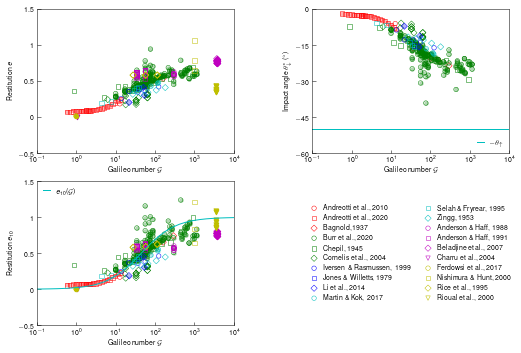

In [27]:
fig = plt.gcf()

S = 20
lw = 0.5
Alpha = 0.3

ax0 = plt.subplot(221)


for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax0.scatter(Ga_opp[temp],e_opp[temp],s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax0.scatter(Ga_opp[temp],e_opp[temp],s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])

for i in range(len(colors_rest)):
    for j in range(len(markers_rest)):
        if i*len(markers_rest)+j<len(uniquerefs_rest):
            temp = np.argwhere(ref_rest==uniquerefs_rest[i*len(markers_rest)+j])
            if uniquerefs_rest[i*len(markers_rest)+j] in ofnoterefs_rest:
                ax0.scatter(Ga_rest[temp],e_rest[temp],s=S,color=colors_rest[i],edgecolor=colors_rest[i],marker=markers_rest[j])
            ax0.scatter(Ga_rest[temp],e_rest[temp],s=S,color='none',edgecolor=colors_rest[i],lw=lw,marker=markers_rest[j])

ax0.set_xscale('log')
ax0.set_xlim(1e-1,1e+4)
ax0.set_ylim(-0.5,1.5)
ax0.set_xlabel('Galileo number $\\mathcal{G}$',fontsize=fs)
ax0.set_ylabel('Restitution $e$',fontsize=fs)
ax0.set_xticks([1e-1,1e+0,1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([-0.5,0,0.5,1,1.5])
ax0.set_yticklabels(['$-0.5$','$0$','$0.5$','$1$','$1.5$'],fontsize=fs)
ax0.legend(frameon=False,fontsize=fs,handlelength=lw*2,loc=2)
plt.minorticks_off()

ax1 = plt.subplot(222)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                plt.scatter(Ga_opp[temp],thetadown_opp[temp]*180./np.pi,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            plt.scatter(Ga_opp[temp],thetadown_opp[temp]*180./np.pi,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])

ax1.plot([1e-1,1e+4],[-thetaup/np.pi*180,-thetaup/np.pi*180],'c',label='$-\\theta_\\uparrow$',lw=lw*2)
ax1.set_xscale('log')
ax1.set_xlim(1e-1,1e+4)
ax1.set_ylim(-60,0)
ax1.set_xticks([1e-1,1e+0,1e+1,1e+2,1e+3,1e+4])
ax1.set_xticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax1.set_yticks([-60,-45,-30,-15,0])
ax1.set_yticklabels(['$-60$','$-45$','$-30$','$-15$','$0$'],fontsize=fs)
plt.minorticks_off()
ax1.set_xlabel('Galileo number $\\mathcal{G}$',fontsize=fs)
ax1.set_ylabel('Impact angle ${\\theta}^*_\\downarrow$ ($^\\circ$)',fontsize=fs)
ax1.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=2,loc=4)

ax2 = plt.subplot(223)

Gatemp = np.logspace(-1,4,30)
ax2.plot(Gatemp,model_e(Gatemp),'c',lw=lw*2,label='$e_{10}(\\mathcal{G})$')

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax2.scatter(Ga_opp[temp],e10_opp[temp],s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax2.scatter(Ga_opp[temp],e10_opp[temp],s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])

for i in range(len(colors_rest)):
    for j in range(len(markers_rest)):
        if i*len(markers_rest)+j<len(uniquerefs_rest):
            temp = np.argwhere(ref_rest==uniquerefs_rest[i*len(markers_rest)+j])
            if uniquerefs_rest[i*len(markers_rest)+j] in ofnoterefs_rest:
                ax2.scatter(Ga_rest[temp],e10_rest[temp],s=S,color=colors_rest[i],edgecolor=colors_rest[i],marker=markers_rest[j])
            ax2.scatter(Ga_rest[temp],e10_rest[temp],s=S,color='none',edgecolor=colors_rest[i],lw=lw,marker=markers_rest[j])

ax2.set_xscale('log')
ax2.set_xlim(1e-1,1e+4)
ax2.set_ylim(-0.5,1.5)
ax2.set_xlabel('Galileo number $\\mathcal{G}$',fontsize=fs)
ax2.set_ylabel('Restitution $e_{10}$',fontsize=fs)
ax2.set_xticks([1e-1,1e+0,1e+1,1e+2,1e+3,1e+4])
ax2.set_xticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax2.set_yticks([-0.5,0,0.5,1,1.5])
ax2.set_yticklabels(['$-0.5$','$0$','$0.5$','$1$','$1.5$'],fontsize=fs)
ax2.legend(frameon=False,fontsize=fs,handlelength=lw*2,loc=2)
plt.minorticks_off()

ax4 = plt.subplot(224)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax4.scatter(Ga_opp[temp],e10_opp[temp],s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax4.scatter(Ga_opp[temp],e10_opp[temp],s=S,color='none',edgecolor=colors[i],marker=markers[j],lw=lw,label=uniquerefsfull[i*len(markers)+j])

for i in range(len(colors_rest)):
    for j in range(len(markers_rest)):
        if i*len(markers_rest)+j<len(uniquerefs_rest):
            temp = np.argwhere(ref_rest==uniquerefs_rest[i*len(markers_rest)+j])
            if uniquerefs_rest[i*len(markers_rest)+j] in ofnoterefs_rest:
                ax4.scatter(Ga_rest[temp],e10_rest[temp],s=S,color=colors_rest[i],edgecolor=colors_rest[i],marker=markers_rest[j])
            ax4.scatter(Ga_rest[temp],e10_rest[temp],s=S,color='none',edgecolor=colors_rest[i],marker=markers_rest[j],lw=lw,label=uniquerefsfull_rest[i*len(markers_rest)+j])

ax4.set_xlim(-10,-9)
ax4.set_ylim(-10,-9)
ax4.axis('off')
ax4.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=2,loc='center')

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(bottom=0.065)
fig.subplots_adjust(top=0.98)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig6-rough.pdf', dpi=300)

In [28]:
tmax = 1e+4
verbose = False
thetaup = 50*np.pi/180.

vup_opp_pred = np.empty(Nopp)
us_opp_pred = np.empty(Nopp)
tdown_opp_pred = np.empty(Nopp)
zpeak_opp_pred = np.empty(Nopp)
xdown_opp_pred = np.empty(Nopp)
vdown_opp_pred = np.empty(Nopp)
thetadown_opp_pred = np.empty(Nopp)
flag_opp_pred = []

for i in range(Nopp):
       
    usmin, usmax  = us_opp[i]/10, us_opp[i]*10
    vupmin,vupmax = vup_opp[i]/10, vup_opp[i]*10

    vup_opp_pred[i],us_opp_pred[i],tdown_opp_pred[i],zpeak_opp_pred[i],xdown_opp_pred[i],vdown_opp_pred[i],thetadown_opp_pred[i],flag = impact_threshold(model_e(Ga_opp[i]),d_opp[i],g_opp[i],rho_s_opp[i],rho_f_opp[i],nu_opp[i],T_opp[i],M_opp[i],gamma_opp[i],[vupmin,vupmax],[usmin,usmax],verbose)

    flag_opp_pred.append(flag)

    with open('impact_threshold_pred_opp.pkl', 'wb') as tempfile:
        pickle.dump((vup_opp_pred,us_opp_pred,tdown_opp_pred,zpeak_opp_pred,xdown_opp_pred,vdown_opp_pred,thetadown_opp_pred,flag_opp_pred), tempfile)
    print(us_opp_pred[i]/us_opp[i]-1,i,ref_opp[i],model_e(Ga_opp[i])-e10_opp[i],flag_opp_pred[i])

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)
/home/andle/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


0.03376804909052056 0 bagnold1937 -0.022225327353876168 []
-0.08657529471829206 1 bagnold1937 0.0779354808040218 []
-0.13529547198658576 2 bagnold1937 0.12896343587194792 []
-0.12452660310937291 3 bagnold1937 0.12667110899782996 []
1.7229788799417474 4 chepil1945 -0.31959254287984923 ['vup at floor']
0.7916739915417186 5 chepil1945 -0.155663066740297 []
0.6612836789027501 6 chepil1945 -0.23986113077434795 []
0.4085877320958975 7 chepil1945 -0.18838729315465325 []
0.027658941792637393 8 chepil1945 -0.014990826945761149 []
-0.011252788609227626 9 chepil1945 0.008281000823580076 []
-0.13008670121083343 10 chepil1945 0.11471802068967807 []
-0.13987995002218523 11 chepil1945 0.13222690043721586 []
-0.19521046358989058 12 chepil1945 0.19457489541070105 []
-0.09675866860037341 13 chepil1945 0.10307468835212241 []
0.041116745005610245 14 chepil1945 -0.04634738986707865 []
-0.10718053908914427 15 zingg1953 0.05825133393865406 []
-0.23057312012761122 16 zingg1953 0.155696533238517 []
-0.31101738

In [29]:
with open('impact_threshold_pred_opp.pkl', 'rb') as tempfile:
    vup_opp_pred,us_opp_pred,tdown_opp_pred,zpeak_opp_pred,xdown_opp_pred,vdown_opp_pred,thetadown_opp_pred,flag_opp_pred = pickle.load(tempfile)

In [30]:
vup = []
us = []
tdown = []
zpeak = []
xdown = []
vdown = []
thetadown = []
flag = []

Nd = 30
d = np.logspace(-5,-2,Nd)

verbose = False
tmax = 1e+4

vup_us_init = [[[5.858077358737998 ,1.162180848045691  ],[5.64543644007688   ,1.1205532610216173 ]],
               [[18.355611467453972,3.57483035118282   ],[17.838144211610445 ,3.4026843410102283 ]],
               [[1.0003731004290586,0.20695750221379705],[0.6349356787200595 ,0.14074077511883412],[0.8797611466629743,0.18324462180107318]],
               [[1.079712709487241 ,0.26386841548191575],[1.0323705383274246 ,0.2555127024434018 ]],
               [[20.862099022400198,5.760107899553169  ],[29.222016500113074 ,7.305434219518522  ]],
               [[33.1861249341642  ,7.764253965538278  ],[17.004772104441027 ,5.043103844477874  ],[19.629319267115328,5.32594245758714   ],[27.653714410731165,6.740105293394218   ]]]

for i in range(Nn):
    vup_TEMP = []
    us_TEMP = []
    tdown_TEMP = []
    zpeak_TEMP = []
    xdown_TEMP = []
    vdown_TEMP = []
    thetadown_TEMP = []
    flag_TEMP = []
    for j in range(len(sediment[i])):
        vup_temp = np.empty((NT,Np,Nd))
        us_temp = np.empty((NT,Np,Nd))
        tdown_temp = np.empty((NT,Np,Nd))
        zpeak_temp = np.empty((NT,Np,Nd))
        xdown_temp = np.empty((NT,Np,Nd))
        vdown_temp = np.empty((NT,Np,Nd))
        thetadown_temp = np.empty((NT,Np,Nd))
        flag_temp = [[[[] for ii in range(Nd)] for jj in range(Np)] for kk in range(NT)]
        for k in range(NT):
            for l in range(Np):
                for m in np.arange(Nd-1,-1,-1):
                    Ga_temp = ((rho_s[i][j]/rho_f[i][k,l]-1)*g[i]*d[m]**3)**0.5/nu[i,k,l]
                    if m==Nd-1:
                        usmin, usmax  = vup_us_init[i][j][1]*10**-1,vup_us_init[i][j][1]*10**1
                        vupmin,vupmax = vup_us_init[i][j][0]*10**-1,vup_us_init[i][j][0]*10**1
                        
                        vup_temp[k,l,m],us_temp[k,l,m],tdown_temp[k,l,m],zpeak_temp[k,l,m],xdown_temp[k,l,m],vdown_temp[k,l,m],thetadown_temp[k,l,m],flag_temp[k][l][m] = impact_threshold(model_e(Ga_temp),d[m],g[i],rho_s[i][j],rho_f[i][k,l],nu[i,k,l],T_x[i,k],M[i],gamma[i],[vupmin,vupmax],[usmin,usmax],verbose)
                        
                    else:
                        usmin, usmax  = us_temp[k,l,m+1]*10**-0.25,us_temp[k,l,m+1]*10**0.25
                        vupmin,vupmax = vup_temp[k,l,m+1]*10**-0.75,vup_temp[k,l,m+1]*10**0.75
                        
                        vup_temp[k,l,m],us_temp[k,l,m],tdown_temp[k,l,m],zpeak_temp[k,l,m],xdown_temp[k,l,m],vdown_temp[k,l,m],thetadown_temp[k,l,m],flag_temp[k][l][m] = impact_threshold(model_e(Ga_temp),d[m],g[i],rho_s[i][j],rho_f[i][k,l],nu[i,k,l],T_x[i,k],M[i],gamma[i],[vupmin,vupmax],[usmin,usmax],verbose)

                    print(name[i],sediment[i][j],k,l,m,flag_temp[k][l][m])
        vup_TEMP.append(vup_temp)
        us_TEMP.append(us_temp)
        tdown_TEMP.append(tdown_temp)
        zpeak_TEMP.append(zpeak_temp)
        xdown_TEMP.append(xdown_temp)
        vdown_TEMP.append(vdown_temp)
        thetadown_TEMP.append(thetadown_temp)
        flag_TEMP.append(flag_temp)
    vup.append(vup_TEMP)
    us.append(us_TEMP)
    tdown.append(tdown_TEMP)
    zpeak.append(zpeak_TEMP)
    xdown.append(xdown_TEMP)
    vdown.append(vdown_TEMP)
    thetadown.append(thetadown_TEMP)
    flag.append(flag_TEMP)
    
    with open('impact_threshold_pred.pkl', 'wb') as tempfile:
        pickle.dump((vup,us,tdown,zpeak,xdown,vdown,thetadown,flag,d), tempfile)

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


Earth Quartz 0 0 29 []
Earth Quartz 0 0 28 []
Earth Quartz 0 0 27 []
Earth Quartz 0 0 26 []
Earth Quartz 0 0 25 []
Earth Quartz 0 0 24 []
Earth Quartz 0 0 23 []
Earth Quartz 0 0 22 []
Earth Quartz 0 0 21 []
Earth Quartz 0 0 20 []
Earth Quartz 0 0 19 []
Earth Quartz 0 0 18 []
Earth Quartz 0 0 17 []
Earth Quartz 0 0 16 []
Earth Quartz 0 0 15 []
Earth Quartz 0 0 14 []
Earth Quartz 0 0 13 []
Earth Quartz 0 0 12 []
Earth Quartz 0 0 11 []
Earth Quartz 0 0 10 []
Earth Quartz 0 0 9 []
Earth Quartz 0 0 8 []
Earth Quartz 0 0 7 []
Earth Quartz 0 0 6 []
Earth Quartz 0 0 5 []
Earth Quartz 0 0 4 []
Earth Quartz 0 0 3 ['vup at floor', 'vup << us']
Earth Quartz 0 0 2 ['vupmin << usmin', 'vup at floor', 'vup << us']
Earth Quartz 0 0 1 ['vupmin << usmin', 'vup at floor', 'vup << us']
Earth Quartz 0 0 0 ['vupmin << usmin', 'vup at floor', 'vup << us']
Earth Quartz 0 1 29 []
Earth Quartz 0 1 28 []
Earth Quartz 0 1 27 []
Earth Quartz 0 1 26 []
Earth Quartz 0 1 25 []
Earth Quartz 0 1 24 []
Earth Quartz 0 1 

In [31]:
with open('impact_threshold_pred.pkl', 'rb') as tempfile:
    vup,us,tdown,zpeak,xdown,vdown,thetadown,flag,d = pickle.load(tempfile)
Nd = 30

In [32]:
us_flagged = np.copy(us)
vdown_flagged = np.copy(vdown)
tdown_flagged = np.copy(tdown)
zpeak_flagged = np.copy(zpeak)
xdown_flagged = np.copy(xdown)
thetadown_flagged = np.copy(thetadown)

for i in range(Nn):
    for j in range(len(sediment[i])):
        for k in range(NT):
            for l in range(Np):
                for m in range(Nd):
                    if ('vup << us' in flag[i][j][k][l][m]) or ('vup at floor' in flag[i][j][k][l][m]):
                        us_flagged[i][j][k,l,m] = np.nan
                        vdown_flagged[i][j][k,l,m] = np.nan
                        tdown_flagged[i][j][k,l,m] = np.nan
                        zpeak_flagged[i][j][k,l,m] = np.nan
                        thetadown_flagged[i][j][k,l,m] = np.nan
#                     if i==0 and j==0 and m==4:
#                         us_flagged[i][j][k,l,m] = np.nan
#                         vdown_flagged[i][j][k,l,m] = np.nan
        print(i,j)
        print(np.argwhere(xdown_flagged[i][j]/d[np.newaxis,np.newaxis,:]==np.nanmin(xdown_flagged[i][j]/d[np.newaxis,np.newaxis,:])))
        print(np.nanmin(xdown_flagged[i][j]/d[np.newaxis,np.newaxis,:]))

0 0
[[0 1 0]]
0.0024276109087816686
0 1
[[1 1 0]]
0.0017561255485465655
1 0
[[0 1 4]]
2555.9672811948585
1 1
[[0 1 4]]
2566.8911997270707
2 0
[[1 0 0]]
1.922409927868678e-05
2 1
[[1 0 0]]
6.332499722863831e-08
2 2
[[0 1 0]]
9.221905793486388e-07
3 0
[[1 0 0]]
7.065739045503667e-06
3 1
[[1 1 0]]
2.636282747158779e-06
4 0
[[0 1 8]]
64286.12517174201
4 1
[[0 1 6]]
110475.76537414057
5 0
[[1 1 6]]
102408.37938894631
5 1
[[1 1 9]]
53116.61792802186
5 2
[[0 1 8]]
51086.19207068704
5 3
[[1 1 7]]
81948.7597486016


/home/andle/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [33]:
i = 3 
j = 1
k = 0 
l = 1 
m = 10

Nt = 100

sol = solve_ivp(ivp,[0,tmax],[0+d[m]/2.*1j,vup[i][j][k,l,m]*np.exp(1j*thetaup)],t_eval=np.linspace(0,tdown[i][j][k,l,m],Nt),args=(us[i][j][k,l,m],d[m],g[i],rho_s[i][j],rho_f[i][k,l],nu[i][k,l],T_x[i][k],M[i],gamma[i]),events=(peak,end))

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


In [34]:
with open('fluid_threshold_pred.pkl', 'rb') as tempfile:
    us_fluid,_,_,_,_,_,_,_,_,_,_,_ = pickle.load(tempfile)

In [35]:
verbose = False

vdownmax_master = []
vdownmin_master = []
usmax_master = []
usmin_master = []


for i in range(Nn):
    vdownmax_masterTEMP = []
    vdownmin_masterTEMP = []
    usmax_masterTEMP = []
    usmin_masterTEMP = []    
    for j in range(len(sediment[i])):
        vdownmax_mastertemp = np.empty(Nd)
        vdownmin_mastertemp = np.empty(Nd)
        usmin = np.empty((NT,Np,Nd))
        for k in range(NT):
            for l in range(Np):
                usmin[k,l,:] = np.min(np.vstack((us_flagged[i][j][k,l],us_fluid[i][j][k,l])),axis=0)
        tempmin = np.min(np.min(usmin,axis=0),axis=0)
        tempmax = np.max(np.max(usmin,axis=0),axis=0)
        for m in range(Nd):
            try:
                impact_inds = np.argwhere(us_flagged[i][j][:,:,m]==tempmax[m])[0]
                vdownmax_mastertemp[m] = vdown_flagged[i][j][impact_inds[0],impact_inds[1],m]
            except:
                try:
                    fluid_inds = np.argwhere(us_fluid[i][j][:,:,m]==tempmax[m])[0]

                    print('entering optimization...')
                    vupbounds = [tempmax[m]/100,tempmax[m]*100]
                    _,_,_,_,_,tempvdown,_,tempflag = restitution_opp(tempmax[m],
                                                                 d[m],
                                                                 g[i],
                                                                 rho_s[i][j],
                                                                 rho_f[i,fluid_inds[0],fluid_inds[1]],
                                                                 nu[i,fluid_inds[0],fluid_inds[1]],
                                                                 T_x[i,fluid_inds[0]],
                                                                 M[i],
                                                                 gamma[i],
                                                                 vupbounds,
                                                                 verbose)
                    
                    if ('vup << us' in tempflag) or ('vup at floor' in tempflag):
                        vdownmax_mastertemp[m] = np.nan
                        print(tempflag)
                    else:
                        vdownmax_mastertemp[m] = tempvdown
                        print(tempvdown)
                except:
                    vdownmax_mastertemp[m] = np.nan
                
            try:
                impact_inds = np.argwhere(us_flagged[i][j][:,:,m]==tempmin[m])[0]
                vdownmin_mastertemp[m] = vdown_flagged[i][j][impact_inds[0],impact_inds[1],m]
            except:
                try:
                    fluid_inds = np.argwhere(us_fluid[i][j][:,:,m]==tempmin[m])[0]

                    print('entering optimization...')
                    vupbounds = [tempmin[m]/100,tempmin[m]*100]
                    
                    _,_,_,_,_,tempvdown,_,tempflag = restitution_opp(tempmin[m],
                                                                 d[m],
                                                                 g[i],
                                                                 rho_s[i][j],
                                                                 rho_f[i,fluid_inds[0],fluid_inds[1]],
                                                                 nu[i,fluid_inds[0],fluid_inds[1]],
                                                                 T_x[i,fluid_inds[0]],
                                                                 M[i],
                                                                 gamma[i],
                                                                 vupbounds,
                                                                 verbose)
                    
                    if ('vup << us' in tempflag) or ('vup at floor' in tempflag):
                        vdownmin_mastertemp[m] = np.nan
                        print(tempflag)
                    else:
                        vdownmin_mastertemp[m] = tempvdown
                        print(tempvdown)
                        
                except:
                    vdownmin_mastertemp[m] = np.nan
                
        vdownmax_masterTEMP.append(vdownmax_mastertemp)
        vdownmin_masterTEMP.append(vdownmin_mastertemp)
        usmax_masterTEMP.append(tempmax)
        usmin_masterTEMP.append(tempmin)        
        print(name[i],sediment[i][j])
    vdownmax_master.append(vdownmax_masterTEMP)
    vdownmin_master.append(vdownmin_masterTEMP)
    usmax_master.append(usmax_masterTEMP)
    usmin_master.append(usmin_masterTEMP)

entering optimization...


<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


0.7669429395628423
entering optimization...
0.8685662909960171
entering optimization...
1.222403056833709
entering optimization...
1.3030640951857237
entering optimization...
1.6320136530913398
entering optimization...
1.5219715154515903
entering optimization...
2.0515000753158636
entering optimization...
1.8708207221941526
entering optimization...
2.498751552069937
Earth Quartz
entering optimization...
1.2066955063843707
entering optimization...
1.319332688137675
entering optimization...
1.6164448157404814
entering optimization...
1.6241940518971432
entering optimization...
1.95421487236286
entering optimization...
1.8666110673163743
entering optimization...
2.278813749970617
Earth Gypsum
entering optimization...
20.30304200394753
entering optimization...
22.21022709544792
entering optimization...
23.32587137290881
Mars Basalt
entering optimization...
15.057574006310821
entering optimization...
17.783067653050068
entering optimization...
20.23707452821211
entering optimization...
21.1

In [36]:
Nbin = 25

Bbins = np.logspace(np.log10(2e-2),np.log10(2e+1),Nbin)
Bhist = np.histogram2d(us_opp,us_opp_pred,bins=Bbins)
Bhist[0][Bhist[0]==0] = np.nan

Ebinsx = np.logspace(-1,4,Nbin)
Ebinsy = np.linspace(-0.5,1.5,Nbin)
Ehist = np.histogram2d(Ga_fit,e10_fit,bins=(Ebinsx,Ebinsy))
Ehist[0][Ehist[0]==0] = np.nan

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)
/home/andle/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


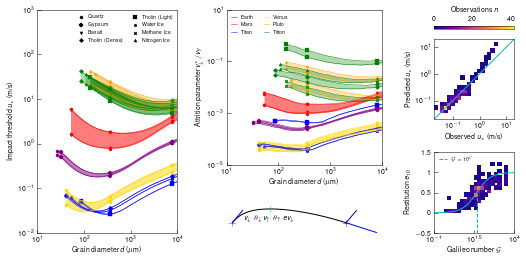

In [37]:
y0temp = 0.54
x0temp = 0.83
sxtemp = 1-x0temp-0.015
sytemp = 0.32
mxtemp = 0.3
mytemp = 0.5
cbarybuff = 0.04
xbuff = 0.1

Nint = 60

lw = 0.5
Alpha = 0.3
S = 10
histvmax = np.max([np.nanmax(Bhist[0]),np.nanmax(Ehist[0])])
histcolormap = 'plasma'
oppcolor = cm.plasma(0.5)

dus_patches = []

for i in range(Nn):
    dus_patchestemp = []
    for j in range(len(sediment[i])):
 
        temp = np.copy(us_flagged[i][j])
    
        d_ij = np.hstack((d*1e+6,np.flip(d*1e+6)))
        us_ij = np.hstack((np.min(np.min(temp,axis=0),axis=0),np.flip(np.max(np.max(temp,axis=0),axis=0))))
        d_ij = np.delete(d_ij,np.argwhere(np.isnan(us_ij)))
        us_ij = np.delete(us_ij,np.argwhere(np.isnan(us_ij)))
        dus_patchestemp.append(PolygonPatch(Polygon(np.vstack((d_ij,us_ij)).T), alpha=Alpha, fc=color[i], ec=color[i], lw=0))
        
    dus_patches.append(dus_patchestemp)    

#######

fig = plt.gcf()
    
ax0 = fig.add_axes([0.065, 0.09, 1-(0.01+mxtemp+xbuff+sytemp), 0.885])

for i in range(Nn):
    for j in range(len(sediment[i])):
        
        usmintemp = np.min(np.min(us_flagged[i][j],axis=0),axis=0)
        dtemp = np.delete(d,np.argwhere(np.isnan(usmintemp)))
        usmintemp = np.delete(usmintemp,np.argwhere(np.isnan(usmintemp)))
        usmaxtemp = np.max(np.max(us_flagged[i][j],axis=0),axis=0)
        usmaxtemp = np.delete(usmaxtemp,np.argwhere(np.isnan(usmaxtemp)))

        ax0.plot(dtemp*1e+6,usmintemp,c=color[i],lw=lw)
        ax0.plot(dtemp*1e+6,usmaxtemp,c=color[i],lw=lw)
        ax0.scatter(dtemp[0]*1e+6,usmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(dtemp[-2]*1e+6,usmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(dtemp[0]*1e+6,usmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(dtemp[-2]*1e+6,usmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(dtemp[-int(Nd/2)]*1e+6,usmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
        ax0.scatter(dtemp[-int(Nd/2)]*1e+6,usmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

        ax0.add_patch(dus_patches[i][j])

        
for i in range(len(classify_sediments)):
    ax0.scatter([-1],[-1],s=S,c='k',lw=lw/2.,marker=classify_sediments[i][1],label=classify_sediments[i][0])
ax0.legend(frameon=False,fontsize=fs*0.75,handlelength=lw*2,ncol=2)


ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e+1,1e+4)
ax0.set_ylim(1e-2,1e+3)
ax0.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax0.set_ylabel('Impact threshold $u_{*}$ (m/s)',fontsize=fs)
ax0.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2,1e+3])
ax0.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'],fontsize=fs)
plt.minorticks_off()

ax1 = fig.add_axes([x0temp-mxtemp-xbuff, y0temp+sytemp-mytemp, mxtemp, (0.09+0.885)-(y0temp+sytemp-mytemp)])

for i in range(Nn):
    for j in range(len(sediment[i])):
        tempmin = np.min(np.min(vdown_flagged[i][j]/vY[i][j][:,np.newaxis],axis=0),axis=0)
        tempmax = np.max(np.max(vdown_flagged[i][j]/vY[i][j][:,np.newaxis],axis=0),axis=0)

        dtemp = np.delete(d,np.argwhere(np.isnan(tempmin)))
        tempmaxtemp = np.delete(tempmax,np.argwhere(np.isnan(tempmax)))
        tempmintemp = np.delete(tempmin,np.argwhere(np.isnan(tempmin)))

        if i==0:
            
            ax1.fill_between(dtemp[1:]*1e+6,tempmintemp[1:],tempmaxtemp[1:],alpha=Alpha,lw=0,color=color[i])
            ax1.plot(dtemp[1:]*1e+6,tempmintemp[1:],c=color[i],lw=lw)
            ax1.plot(dtemp[1:]*1e+6,tempmaxtemp[1:],c=color[i],lw=lw)
            ax1.scatter(dtemp[1]*1e+6,tempmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[1]*1e+6,tempmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
       
        else:
                     
            ax1.fill_between(d*1e+6,tempmin,tempmax,alpha=Alpha,lw=0,color=color[i])
            ax1.plot(dtemp*1e+6,tempmintemp,c=color[i],lw=lw)
            ax1.plot(dtemp*1e+6,tempmaxtemp,c=color[i],lw=lw)
            ax1.scatter(dtemp[0]*1e+6,tempmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[0]*1e+6,tempmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

for i in range(Nn):
    ax1.plot([-1,-1],[-1,-1],c=color[i],lw=lw,label=name[i])
ax1.legend(frameon=False,fontsize=fs*0.75,handlelength=lw*2,ncol=2,loc=2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e+1,1e+4)
ax1.set_ylim(1e-5,1e+1)
ax1.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax1.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax1.set_yticks([1e-5,1e-3,1e-1,1e+1])
ax1.set_yticklabels(['$10^{-5}$','$10^{-3}$','$10^{-1}$','$10^{1}$'],fontsize=fs)
plt.minorticks_off()
ax1.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax1.set_ylabel('Attrition parameter ${v}^*_\\downarrow /v_Y$',fontsize=fs)


ax2 = fig.add_axes([x0temp, y0temp, sxtemp, sytemp])

s0 = ax2.pcolormesh(Bhist[1],Bhist[2],Bhist[0].T,rasterized=True,vmin=0,vmax=histvmax,cmap=histcolormap)
ax2.plot([2e-2,2e+1],[2e-2,2e+1],'c',lw=lw*2)
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.axis('square')
ax2.set_xlim(2e-2,2e+1)
ax2.set_ylim(2e-2,2e+1)
ax2.set_xlabel('Observed $u_{*}$ (m/s)',fontsize=fs)
ax2.set_ylabel('Predicted $u_{*}$ (m/s)',fontsize=fs)
ax2.set_xticks([1e-1,1e+0,1e+1])
ax2.set_xticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)
ax2.set_yticks([1e-1,1e+0,1e+1])
ax2.set_yticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)
plt.minorticks_off()

ax4 = fig.add_axes([x0temp, 0.09, sxtemp, sytemp])

Gatemp = np.logspace(-1,4,30)

s1 = ax4.pcolormesh(Ehist[1],Ehist[2],Ehist[0].T,rasterized=True,vmin=0,vmax=histvmax,cmap=histcolormap)
ax4.plot(Gatemp,model_e(Gatemp),'c',lw=lw*2)
ax4.plot([10**fitD,10**fitD],[-0.5,0.5],'--c',lw=lw*2,label='$\\mathcal{G} = 10^\\mathcal{C}$')
ax4.set_xscale('log')
ax4.set_xlim(1e-1,1e+4)
ax4.set_ylim(-0.5,1.5)
ax4.set_xlabel('Galileo number $\\mathcal{G}$',fontsize=fs)
ax4.set_ylabel('Restitution $e_{10}$',fontsize=fs)
ax4.set_xticks([1e-1,10**1.5,1e+4])
ax4.set_xticklabels(['$10^{-1}$','$10^{1.5}$','$10^{4}$'],fontsize=fs)
ax4.set_yticks([-0.5,0,0.5,1,1.5])
ax4.set_yticklabels(['$-0.5$','$0$','$0.5$','$1$','$1.5$'],fontsize=fs)
ax4.tick_params('both', width=lw, which='major')
plt.minorticks_off()
ax4.legend(frameon=False,fontsize=fs*0.75,handlelength=lw*3,loc=2)

ax3 = fig.add_axes([x0temp-mxtemp-xbuff, 0.05, mxtemp, 0.25])

i = 3 
j = 0
k = 0 
l = 1 
m = 10
Nt = 100
sol = solve_ivp(ivp,[0,tmax],[0+d[m]/2.*1j,vup[i][j][k,l,m]*np.exp(1j*thetaup)],t_eval=np.linspace(0,tdown[i][j][k,l,m],Nt),args=(us[i][j][k,l,m],d[m],g[i],rho_s[i][j],rho_f[i][k,l],nu[i][k,l],T_x[i][k],M[i],gamma[i]),events=(peak,end))
vscale = 0.003

ax3.plot(sol.y[0].real,sol.y[0].imag,'k',lw=lw*2)
ax3.plot([0,0],[0,d[m]],'r',lw=lw)
ax3.plot([-d[m]/2,d[m]/2],[d[m]/2,d[m]/2],'r',lw=lw)
ax3.plot([sol.y_events[-1][0][0].real-d[m]/2,sol.y_events[-1][0][0].real+d[m]/2],[sol.y_events[-1][0][0].imag,sol.y_events[-1][0][0].imag],'b',lw=lw)
ax3.plot([sol.y_events[-1][0][0].real,sol.y_events[-1][0][0].real],[sol.y_events[-1][0][0].imag-d[m]/2,sol.y_events[-1][0][0].imag+d[m]/2],'b',lw=lw)
ax3.plot([sol.y_events[0][0][0].real-d[m]/2,sol.y_events[0][0][0].real+d[m]/2],[sol.y_events[0][0][0].imag,sol.y_events[0][0][0].imag],'c',lw=lw)
ax3.plot([sol.y_events[0][0][0].real,sol.y_events[0][0][0].real],[sol.y_events[0][0][0].imag-d[m]/2,sol.y_events[0][0][0].imag+d[m]/2],'c',lw=lw)
ax3.plot([sol.y_events[-1][0][0].real,sol.y_events[-1][0][0].real+vdown[i][j][k,l,m]*np.exp(1j*thetadown[i][j][k,l,m]).real*vscale],
         [sol.y_events[-1][0][0].imag,sol.y_events[-1][0][0].imag+vdown[i][j][k,l,m]*np.exp(1j*thetadown[i][j][k,l,m]).imag*vscale],'b',lw=lw*2)
ax3.plot([sol.y_events[-1][0][0].real,sol.y_events[-1][0][0].real+vup[i][j][k,l,m]*np.exp(1j*thetaup).real*vscale],
         [sol.y_events[-1][0][0].imag,sol.y_events[-1][0][0].imag+vup[i][j][k,l,m]*np.exp(1j*thetaup).imag*vscale],'b',lw=lw*2)
ax3.plot([0,vup[i][j][k,l,m]*np.exp(1j*thetaup).real*vscale],
         [d[m]/2,d[m]/2+vup[i][j][k,l,m]*np.exp(1j*thetaup).imag*vscale],'b',lw=lw*2)
ax3.text(d[m]*2,d[m],'$v_\\downarrow$ $\\theta_\\downarrow$ $v_\\uparrow$ $\\theta_\\uparrow$ $ev_\\downarrow$',fontsize=fs)

ax3.axis('square')
ax3.set_xlim(-d[m],sol.y_events[-1][0][0].real+d[m]+vdown[i][j][k,l,m]*np.exp(1j*thetadown[i][j][k,l,m]).real*vscale)
ax3.set_ylim(-d[m]+vdown[i][j][k,l,m]*np.exp(1j*thetadown[i][j][k,l,m]).imag*vscale,sol.y_events[0][0][0].real+d[m])
ax3.axis('off')

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0)
fig.subplots_adjust(top=1)
fig.subplots_adjust(right=1)
fig.subplots_adjust(left=0)

cbar1_ax = fig.add_axes([x0temp, y0temp+sytemp+cbarybuff, sxtemp, 0.01])
c1 = fig.colorbar(s1, orientation='horizontal',cax=cbar1_ax, ticks=[0,20,40])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
c1.set_label('Observations $n$',fontsize=fs)
c1.ax.set_xticklabels(['$0$','$20$','$40$'],fontsize=fs)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(183./25.4, 89/25.4, forward=True)
# plt.savefig('fig3-rough.pdf', dpi=300)

In [38]:
tmax = 1e+4
usmin, usmax  = 1e-2,1e+1
vupmin,vupmax = 1e-3,1e+2
verbose = True

thetaup = 50*np.pi/180.

i = 0
j = 0

g_temp  = g[i]
rho_s_temp = rho_s[i][j]
rho_f_temp = np.mean(rho_f[i])
nu_temp = np.mean(nu[i])
gamma_temp = gamma[i]
T_temp  = np.mean(T_x[i])
M_temp  = M[i]

d_temp  = 1e-3

e10target = model_e(((rho_s_temp/rho_f_temp-1)*g_temp*d_temp**3.)**0.5/nu_temp)
e10target
vup_thr,us_thr,tdown_thr,zpeak_thr,xdown_thr,vdown_thr,thetadown_thr,flag_thr = impact_threshold(e10target,d_temp,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp,[vupmin,vupmax],[usmin,usmax],verbose)
print(us_thr,vup_thr,flag_thr)

 
 Func-count     x          f(x)          Procedure
    1       -2.51021     -1.42516        initial
    2       0.207624     -2.56315        golden
    3        1.88734      -2.4588        golden
    4       0.763381     -2.73118        parabolic
    5       0.951683     -2.74749        parabolic
    6        1.00686     -2.74701        parabolic
    7       0.968186     -2.74765        parabolic
    8       0.970264      -2.7476        parabolic
    9       0.962626     -2.74765        parabolic
   10       0.958446     -2.74762        golden
   11       0.965339     -2.74766        parabolic


<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)
/home/andle/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


   12       0.965328     -2.74766        parabolic
   13       0.964283     -2.74765        parabolic
   14       0.964929     -2.74765        golden
   15       0.965239     -2.74766        parabolic
   16       0.965302     -2.74766        parabolic
   17       0.965278     -2.74766        golden
   18       0.965299     -2.74766        parabolic
   19       0.965295     -2.74766        parabolic
   20       0.965288     -2.74766        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
 
 Func-count     x          f(x)          Procedure
    1        3.82584     0.808273        initial
 
 Func-count     x          f(x)          Procedure
    1       -2.51021     -1.46705        initial
    2       0.207624     -2.54518        golden
    3        1.88734     -2.83968        golden
    4        2.78906     -2.24935        parabolic
    5        1.32013     -2.94778        parabolic
    6        1.31401     -2.9475

In [39]:
usmin, usmax  = 1e-2,1e+1
vupmin,vupmax = 1e-3,1e+2

Nu = 20
Nv = 30
us_temp  = np.logspace(np.log10(usmin),np.log10(usmax),Nu)

vup_temp = np.logspace(np.log10(vupmin),np.log10(vupmax),Nv)

vdown_temp = np.empty((Nu,Nv))
thetadown_temp = np.empty((Nu,Nv))
zpeak_temp = np.empty((Nu,Nv))
xdown_temp = np.empty((Nu,Nv))
tdown_temp = np.empty((Nu,Nv)) 

for i in range(Nu):
    for j in range(Nv):
        sol = solve_ivp(ivp,[0,tmax],[0+d_temp/2.*1j,vup_temp[j]*np.exp(1j*thetaup)],args=(us_temp[i],d_temp,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp),events=(peak,end))
        Ppeak = sol.y_events[0][0][0]
        Vdown = sol.y_events[-1][0][1]
        Pdown = sol.y_events[-1][0][0]

        tdown_temp[i,j] = sol.t_events[-1][0]
        zpeak_temp[i,j] = Ppeak.imag
        xdown_temp[i,j] = Pdown.real
        vdown_temp[i,j] = np.abs(Vdown)
        thetadown_temp[i,j] = np.angle(Vdown)
    print(i)

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [40]:
solus = us_thr

vdown_solus = np.empty(Nv)
thetadown_solus = np.empty(Nv)
zpeak_solus = np.empty(Nv)
xdown_solus = np.empty(Nv)
tdown_solus = np.empty(Nv) 

for i in range(Nv):
    
    sol = solve_ivp(ivp,[0,tmax],[0+d_temp/2.*1j,vup_temp[i]*np.exp(1j*thetaup)],args=(solus,d_temp,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp),events=(peak,end))
    Ppeak = sol.y_events[0][0][0]
    Vdown = sol.y_events[-1][0][1]
    Pdown = sol.y_events[-1][0][0]
    
    tdown_solus[i] = sol.t_events[-1][0]
    zpeak_solus[i] = Ppeak.imag
    xdown_solus[i] = Pdown.real
    vdown_solus[i] = np.abs(Vdown)
    thetadown_solus[i] = np.angle(Vdown)
    

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


In [41]:
e10_minima = np.empty(Nu)

for i in range(Nu):
    sol = calc_minima_loge10(us_temp[i],d_temp,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp,tmax,vupbounds,False)
    e10_minima[i] = np.exp(sol.fun)
    print(i)

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


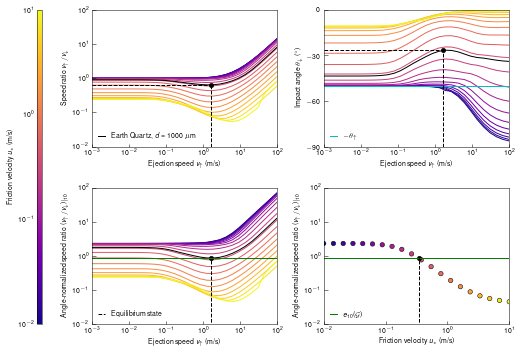

In [42]:
S = 20
lw = 0.5

fig = plt.gcf()

cmp_string = 'plasma'
cmpf = plt.cm.get_cmap(cmp_string)

ax0 = plt.subplot(221)
for i in range(Nu):
    ax0.plot(vup_temp,vup_temp/vdown_temp[i],c=cmpf(i/(Nu-1)),lw=lw*2,zorder=-1)
ax0.plot(vup_temp,vup_temp/vdown_solus,'k',lw=lw*2,label='%s %s, $d$ = %d $\\mu$m'%(name[0],sediment[0][0],1e-3*1e+6))
ax0.plot([vup_thr,vup_thr],[1e-2,vup_thr/vdown_thr],'--k',lw=lw*2)
ax0.plot([vupmin,vup_thr],[vup_thr/vdown_thr,vup_thr/vdown_thr],'--k',lw=lw*2)
ax0.scatter(vup_thr,vup_thr/vdown_thr,c='k',lw=lw,s=S,edgecolor='k')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(vupmin,vupmax)
ax0.set_ylim(1e-2,1e+2)
ax0.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2])
ax0.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax0.set_xticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax0.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax0.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax0.set_ylabel('Speed ratio $v_\\uparrow/v_\\downarrow$',fontsize=fs)
ax0.set_xlabel('Ejection speed $v_\\uparrow$ (m/s)',fontsize=fs)
plt.minorticks_off()

ax1 = plt.subplot(222)
for i in range(Nu):
    ax1.plot(vup_temp,thetadown_temp[i]/np.pi*180,c=cmpf(i/(Nu-1)),lw=lw*2,zorder=-1)
ax1.plot(vup_temp,thetadown_solus/np.pi*180,'k',lw=lw*2)
ax1.plot(vup_temp,-vup_temp/vup_temp*thetaup/np.pi*180,'c',label='$-\\theta_\\uparrow$',lw=lw*2)
ax1.plot([vup_thr,vup_thr],[-90,thetadown_thr/np.pi*180],'--k',lw=lw*2)
ax1.plot([vupmin,vup_thr],[thetadown_thr/np.pi*180,thetadown_thr/np.pi*180],'--k',lw=lw*2)
ax1.scatter(vup_thr,thetadown_thr/np.pi*180,c='k',lw=lw,s=S,edgecolor='k')
ax1.set_xscale('log')
ax1.set_xlim(vupmin,vupmax)
ax1.set_ylim(-90,0)
ax1.set_yticks([-90,-60,-30,0])
ax1.set_yticklabels(['$-90$','$-60$','$-30$','$0$'],fontsize=fs)
ax1.set_xticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax1.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax1.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax1.set_ylabel('Impact angle $\\theta_\\downarrow$ ($^{\\circ}$)',fontsize=fs)
ax1.set_xlabel('Ejection speed $v_\\uparrow$ (m/s)',fontsize=fs)
plt.minorticks_off()

ax2 = plt.subplot(223)
for i in range(Nu):
    ax2.plot(vup_temp,calc_e10_from_e(vup_temp/vdown_temp[i],-thetadown_temp[i]),c=cmpf(i/(Nu-1)),lw=lw*2,zorder=-1)
ax2.plot(vup_temp,calc_e10_from_e(vup_temp/vdown_solus,-thetadown_solus),c='k',lw=lw*2)
ax2.plot([vup_thr,vup_thr],[0,e10target],'--k',lw=lw*2,label='Equilibrium state')
ax2.plot(vup_temp,vup_temp/vup_temp*e10target,'g',lw=lw*2)
ax2.scatter(vup_thr,e10target,c='k',lw=lw,s=S,edgecolor='k')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(vupmin,vupmax)
ax2.set_ylim(1e-2,1e+2)
ax2.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2])
ax2.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax2.set_xticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax2.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax2.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax2.set_ylabel('Angle-normalized speed ratio $(v_\\uparrow/v_\\downarrow)|_{10}$',fontsize=fs)
ax2.set_xlabel('Ejection speed $v_\\uparrow$ (m/s)',fontsize=fs)
plt.minorticks_off()

ax3 = plt.subplot(224)
ax3.scatter(us_temp,e10_minima,c=np.log10(us_temp),cmap='plasma',vmin=np.log10(usmin),vmax=np.log10(usmax),lw=lw,s=S,edgecolor='k')
ax3.scatter(us_thr,calc_e10_from_e(vup_thr/vdown_thr,-thetadown_thr),c='k',lw=lw,s=S,edgecolor='k')
ax3.plot(us_temp,us_temp/us_temp*e10target,'g',label='$e_{10}(\\mathcal{G})$',lw=lw*2)
ax3.plot([us_thr,us_thr],[0,e10target],'--k',lw=lw*2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(usmin,usmax)
ax3.set_ylim(1e-2,1e+2)
ax3.set_yticks([1e-2,1e-1,1e+0,1e+1,1e+2])
ax3.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax3.set_xticks([1e-2,1e-1,1e+0,1e+1])
ax3.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)
ax3.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax3.set_ylabel('Angle-normalized speed ratio  $(v_\\uparrow/v_\\downarrow)|_{10}$',fontsize=fs)
ax3.set_xlabel('Friction velocity $u_*$ (m/s)',fontsize=fs)
plt.minorticks_off()

s0 = ax3.scatter(-1,-1,c=1,cmap='plasma',vmin=np.log10(usmin),vmax=np.log10(usmax))

cbar_ax = fig.add_axes([0.065, 0.065, 0.01, 0.975-0.065])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[-2,-1,0,1])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('Friction velocity $u_*$ (m/s)',fontsize=fs)
c0.ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$'],fontsize=fs)

fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(bottom=0.065)
fig.subplots_adjust(top=0.975)
fig.subplots_adjust(right=0.975)
fig.subplots_adjust(left=0.17)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig7-rough.pdf', dpi=300)

In [43]:
tmax = 1e+4
verbose = True

thetaup = 50*np.pi/180.

i = 1
j = 0

g_temp  = g[i]
rho_s_temp = rho_s[i][j]
rho_f_temp = np.mean(rho_f[i])
nu_temp = np.mean(nu[i])
gamma_temp = gamma[i]
T_temp  = np.mean(T_x[i])
M_temp  = M[i]

d_temp0  = 1e-3
d_temp1  = 1e-5

usmin, usmax  = 1e+0,1e+2
vupmin,vupmax = 1e-3,1e+2

Nu = 20
Nv = 30
us_temp  = np.logspace(np.log10(usmin),np.log10(usmax),Nu)

vup_temp = np.logspace(np.log10(vupmin),np.log10(vupmax),Nv)

vdown_temp0 = np.empty((Nu,Nv))
thetadown_temp0 = np.empty((Nu,Nv))
vdown_temp1 = np.empty((Nu,Nv))
thetadown_temp1 = np.empty((Nu,Nv))

for i in range(Nu):
    for j in range(Nv):
        sol = solve_ivp(ivp,[0,tmax],[0+d_temp0/2.*1j,vup_temp[j]*np.exp(1j*thetaup)],args=(us_temp[i],d_temp0,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp),events=(peak,end))
        Vdown = sol.y_events[-1][0][1]
        vdown_temp0[i,j] = np.abs(Vdown)
        thetadown_temp0[i,j] = np.angle(Vdown)
        
        sol = solve_ivp(ivp,[0,tmax],[0+d_temp1/2.*1j,vup_temp[j]*np.exp(1j*thetaup)],args=(us_temp[i],d_temp1,g_temp,rho_s_temp,rho_f_temp,nu_temp,T_temp,M_temp,gamma_temp),events=(peak,end))
        Vdown = sol.y_events[-1][0][1]
        vdown_temp1[i,j] = np.abs(Vdown)
        thetadown_temp1[i,j] = np.angle(Vdown)
        
    print(i)

<ipython-input-4-0285c24aed20>:13: RuntimeWarning: invalid value encountered in double_scalars
  return u_s*(7.*np.arctan(zp/7.)+7./3.*np.arctan(zp/7.)**3.-0.52*np.arctan(zp/7.)**4.+np.log(1.+(zp/c)**(1./kappa))-np.log(1.+0.3*dp*(1.-np.exp(-dp/26.)))/kappa)
/home/andle/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


No handles with labels found to put in legend.


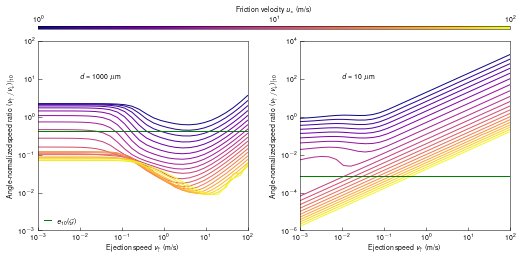

In [44]:
S = 20
lw = 0.5

fig = plt.gcf()

cmp_string = 'plasma'
cmpf = plt.cm.get_cmap(cmp_string)

ax2 = plt.subplot(121)
for i in range(Nu):
    ax2.plot(vup_temp,calc_e10_from_e(vup_temp/vdown_temp0[i],-thetadown_temp0[i]),c=cmpf(i/(Nu-1)),lw=lw*2)
ax2.plot(vup_temp,vup_temp/vup_temp*model_e(((rho_s_temp/rho_f_temp-1)*g_temp*d_temp0**3.)**0.5/nu_temp),'g',lw=lw*2,label='$e_{10}(\\mathcal{G})$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(vupmin,vupmax)
ax2.set_ylim(1e-3,1e+2)
ax2.set_yticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax2.set_yticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax2.set_xticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax2.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax2.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax2.set_ylabel('Angle-normalized speed ratio $(v_\\uparrow/v_\\downarrow)|_{10}$',fontsize=fs)
ax2.set_xlabel('Ejection speed $v_\\uparrow$ (m/s)',fontsize=fs)
ax2.text(1e-2, 1e+1, '$d$ = %d $\\mu$m'%(d_temp0*1e+6),fontsize=fs)
plt.minorticks_off()

ax3 = plt.subplot(122)
for i in range(Nu):
    ax3.plot(vup_temp,calc_e10_from_e(vup_temp/vdown_temp1[i],-thetadown_temp1[i]),c=cmpf(i/(Nu-1)),lw=lw*2)
ax3.plot(vup_temp,vup_temp/vup_temp*model_e(((rho_s_temp/rho_f_temp-1)*g_temp*d_temp1**3.)**0.5/nu_temp),'g',lw=lw*2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(vupmin,vupmax)
ax3.set_ylim(1e-6,1e+4)
ax3.set_yticks([1e-6,1e-4,1e-2,1e+0,1e+2,1e+4])
ax3.set_yticklabels(['$10^{-6}$','$10^{-4}$','$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
ax3.set_xticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax3.set_xticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
ax3.legend(frameon=False,fontsize=fs,loc=3,handlelength=lw*2)
ax3.set_ylabel('Angle-normalized speed ratio $(v_\\uparrow/v_\\downarrow)|_{10}$',fontsize=fs)
ax3.set_xlabel('Ejection speed $v_\\uparrow$ (m/s)',fontsize=fs)
ax3.text(1e-2, 1e+2, '$d$ = %d $\\mu$m'%(d_temp1*1e+6),fontsize=fs)
plt.minorticks_off()

s0 = ax3.scatter(-1,-1,c=1,cmap='plasma',vmin=np.log10(usmin),vmax=np.log10(usmax))

cbar_ax = fig.add_axes([0.065, 0.9, 0.975-0.065, 0.01])
c0 = fig.colorbar(s0, orientation='horizontal', cax=cbar_ax, ticks=[0,1,2])
cbar_ax.xaxis.set_label_position('top')
cbar_ax.xaxis.set_ticks_position('top')
c0.set_label('Friction velocity $u_*$ (m/s)',fontsize=fs)
c0.ax.set_xticklabels(['$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)

fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(right=0.975)
fig.subplots_adjust(left=0.065)

ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

fig.set_size_inches(183/25.4, 89./25.4, forward=True)
# plt.savefig('exfig8-rough.pdf', dpi=300)

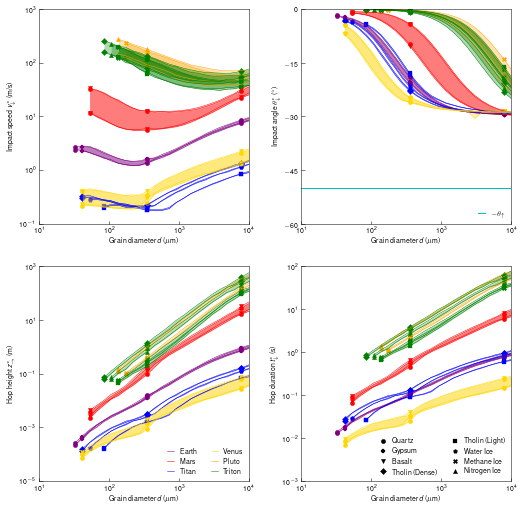

In [45]:
S = 20
lw = 0.5
Alpha = 0.3

fig = plt.gcf()

cmp_string = 'plasma'
cmpf = plt.cm.get_cmap(cmp_string)

ax0 = plt.subplot(221)
for i in range(Nn):
    for j in range(len(sediment[i])):
        tempmin = np.min(np.min(vdown_flagged[i][j],axis=0),axis=0)
        tempmax = np.max(np.max(vdown_flagged[i][j],axis=0),axis=0)

        dtemp = np.delete(d,np.argwhere(np.isnan(tempmin)))
        tempmaxtemp = np.delete(tempmax,np.argwhere(np.isnan(tempmax)))
        tempmintemp = np.delete(tempmin,np.argwhere(np.isnan(tempmin)))

        if i==0:
            
            ax0.fill_between(dtemp[1:]*1e+6,tempmintemp[1:],tempmaxtemp[1:],alpha=Alpha,lw=0,color=color[i])
            ax0.plot(dtemp[1:]*1e+6,tempmintemp[1:],c=color[i],lw=lw)
            ax0.plot(dtemp[1:]*1e+6,tempmaxtemp[1:],c=color[i],lw=lw)
            ax0.scatter(dtemp[1]*1e+6,tempmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[1]*1e+6,tempmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
       
        else:
                     
            ax0.fill_between(d*1e+6,tempmin,tempmax,alpha=Alpha,lw=0,color=color[i])
            ax0.plot(dtemp*1e+6,tempmintemp,c=color[i],lw=lw)
            ax0.plot(dtemp*1e+6,tempmaxtemp,c=color[i],lw=lw)
            ax0.scatter(dtemp[0]*1e+6,tempmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[0]*1e+6,tempmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])


ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e+1,1e+4)
ax0.set_ylim(1e-1,1e+3)
ax0.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([1e-1,1e+0,1e+1,1e+2,1e+3])
ax0.set_yticklabels(['$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'],fontsize=fs)
plt.minorticks_off()
ax0.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax0.set_ylabel('Impact speed ${v}^*_\\downarrow$ (m/s)',fontsize=fs)

ax1 = plt.subplot(222)
for i in range(Nn):
    for j in range(len(sediment[i])):
        tempmin = np.min(np.min(thetadown_flagged[i][j]*180/np.pi,axis=0),axis=0)
        tempmax = np.max(np.max(thetadown_flagged[i][j]*180/np.pi,axis=0),axis=0)

        dtemp = np.delete(d,np.argwhere(np.isnan(tempmin)))
        tempmaxtemp = np.delete(tempmax,np.argwhere(np.isnan(tempmax)))
        tempmintemp = np.delete(tempmin,np.argwhere(np.isnan(tempmin)))

        if i==0:
            
            ax1.fill_between(dtemp[1:]*1e+6,tempmintemp[1:],tempmaxtemp[1:],alpha=Alpha,lw=0,color=color[i])
            ax1.plot(dtemp[1:]*1e+6,tempmintemp[1:],c=color[i],lw=lw)
            ax1.plot(dtemp[1:]*1e+6,tempmaxtemp[1:],c=color[i],lw=lw)
            ax1.scatter(dtemp[1]*1e+6,tempmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[1]*1e+6,tempmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
       
        else:
                     
            ax1.fill_between(d*1e+6,tempmin,tempmax,alpha=Alpha,lw=0,color=color[i])
            ax1.plot(dtemp*1e+6,tempmintemp,c=color[i],lw=lw)
            ax1.plot(dtemp*1e+6,tempmaxtemp,c=color[i],lw=lw)
            ax1.scatter(dtemp[0]*1e+6,tempmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[0]*1e+6,tempmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

ax1.plot(d*1e+6,-d/d*thetaup/np.pi*180,'c',label='$-\\theta_\\uparrow$',lw=lw*2)
ax1.set_xscale('log')
ax1.set_xlim(1e+1,1e+4)
ax1.set_ylim(-60,0)
ax1.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax1.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax1.set_yticks([-60,-45,-30,-15,0])
ax1.set_yticklabels(['$-60$','$-45$','$-30$','$-15$','$0$'],fontsize=fs)
plt.minorticks_off()
ax1.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax1.set_ylabel('Impact angle ${\\theta}^*_\\downarrow$ ($^\\circ$)',fontsize=fs)
ax1.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=2,loc=4)

ax2 = plt.subplot(223)
for i in range(Nn):
    for j in range(len(sediment[i])):
        tempmin = np.min(np.min(zpeak_flagged[i][j],axis=0),axis=0)
        tempmax = np.max(np.max(zpeak_flagged[i][j],axis=0),axis=0)

        dtemp = np.delete(d,np.argwhere(np.isnan(tempmin)))
        tempmaxtemp = np.delete(tempmax,np.argwhere(np.isnan(tempmax)))
        tempmintemp = np.delete(tempmin,np.argwhere(np.isnan(tempmin)))

        if i==0:
            
            ax2.fill_between(dtemp[1:]*1e+6,tempmintemp[1:],tempmaxtemp[1:],alpha=Alpha,lw=0,color=color[i])
            ax2.plot(dtemp[1:]*1e+6,tempmintemp[1:],c=color[i],lw=lw)
            ax2.plot(dtemp[1:]*1e+6,tempmaxtemp[1:],c=color[i],lw=lw)
            ax2.scatter(dtemp[1]*1e+6,tempmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[1]*1e+6,tempmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
       
        else:
                     
            ax2.fill_between(d*1e+6,tempmin,tempmax,alpha=Alpha,lw=0,color=color[i])
            ax2.plot(dtemp*1e+6,tempmintemp,c=color[i],lw=lw)
            ax2.plot(dtemp*1e+6,tempmaxtemp,c=color[i],lw=lw)
            ax2.scatter(dtemp[0]*1e+6,tempmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[0]*1e+6,tempmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e+1,1e+4)
ax2.set_ylim(1e-5,1e+3)
ax2.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax2.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax2.set_yticks([1e-5,1e-3,1e-1,1e+1,1e+3])
ax2.set_yticklabels(['$10^{-5}$','$10^{-3}$','$10^{-1}$','$10^{1}$','$10^{3}$'],fontsize=fs)
plt.minorticks_off()
ax2.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax2.set_ylabel('Hop height ${z}^*_\\rightarrow$ (m)',fontsize=fs)

for i in range(Nn):
    ax2.plot([-1,-1],[-1,-1],c=color[i],lw=lw,label=name[i])
ax2.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=2,loc=4)
   

ax3 = plt.subplot(224)
for i in range(Nn):
    for j in range(len(sediment[i])):
        tempmin = np.min(np.min(tdown_flagged[i][j],axis=0),axis=0)
        tempmax = np.max(np.max(tdown_flagged[i][j],axis=0),axis=0)

        dtemp = np.delete(d,np.argwhere(np.isnan(tempmin)))
        tempmaxtemp = np.delete(tempmax,np.argwhere(np.isnan(tempmax)))
        tempmintemp = np.delete(tempmin,np.argwhere(np.isnan(tempmin)))

        if i==0:
            
            ax3.fill_between(dtemp[1:]*1e+6,tempmintemp[1:],tempmaxtemp[1:],alpha=Alpha,lw=0,color=color[i])
            ax3.plot(dtemp[1:]*1e+6,tempmintemp[1:],c=color[i],lw=lw)
            ax3.plot(dtemp[1:]*1e+6,tempmaxtemp[1:],c=color[i],lw=lw)
            ax3.scatter(dtemp[1]*1e+6,tempmintemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[1]*1e+6,tempmaxtemp[1],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
       
        else:
                     
            ax3.fill_between(d*1e+6,tempmin,tempmax,alpha=Alpha,lw=0,color=color[i])
            ax3.plot(dtemp*1e+6,tempmintemp,c=color[i],lw=lw)
            ax3.plot(dtemp*1e+6,tempmaxtemp,c=color[i],lw=lw)
            ax3.scatter(dtemp[0]*1e+6,tempmintemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-2]*1e+6,tempmintemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[0]*1e+6,tempmaxtemp[0],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-2]*1e+6,tempmaxtemp[-2],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempmintemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])
            ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempmaxtemp[-int(Nd/2)],s=S,c=color[i],lw=lw/2.,marker=marker[i][j])

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1e+1,1e+4)
ax3.set_ylim(1e-3,1e+2)
ax3.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax3.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax3.set_yticks([1e-3,1e-2,1e-1,1e+0,1e+1,1e+2])
ax3.set_yticklabels(['$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$'],fontsize=fs)
plt.minorticks_off()
ax3.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax3.set_ylabel('Hop duration ${t}^*_\\downarrow$ (s)',fontsize=fs)

for i in range(len(classify_sediments)):
    ax3.scatter([-1],[-1],s=S,c='k',lw=lw/2.,marker=classify_sediments[i][1],label=classify_sediments[i][0])
ax3.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=2,loc=4)

fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(bottom=0.065)
fig.subplots_adjust(top=0.975)
fig.subplots_adjust(right=0.975)
fig.subplots_adjust(left=0.065)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)

fig.set_size_inches(183./25.4, 183./25.4, forward=True)
# plt.savefig('exfig9-rough.pdf', dpi=300)

# Comparison

In [46]:
with open('impact_threshold_pred_opp.pkl', 'rb') as tempfile:
    vup_opp_pred,us_opp_pred,tdown_opp_pred,zpeak_opp_pred,xdown_opp_pred,vdown_opp_pred,thetadown_opp_pred,flag_opp_pred = pickle.load(tempfile)

In [48]:
tmax = 1e+4
verbose = False
usbounds_temp = [1e-2,1e+2]

E_temp = 7e+10 #value for quartz referenced in pahtz 2018

us_opp_kok = np.empty(Nopp)
us_opp_pahtz = np.empty(Nopp)
us_opp_claudin = np.empty(Nopp)

for i in range(Nopp):

    us_opp_kok[i] = us_calc_kok(d_opp[i],g_opp[i],rho_s_opp[i],rho_f_opp[i],nu_opp[i])
    us_opp_pahtz[i] = us_calc_pahtz(d_opp[i],g_opp[i],rho_s_opp[i],rho_f_opp[i],nu_opp[i],8e-20/12./np.pi/d0**2.,E_temp)
    us_opp_claudin[i],flag = us_calc_claudin(d_opp[i],g_opp[i],rho_s_opp[i],rho_f_opp[i],nu_opp[i],usbounds_temp,verbose)
    
    print(i,Nopp,flag)

0 264 []
1 264 []
2 264 []
3 264 []
4 264 []
5 264 []
6 264 []
7 264 []
8 264 ['etol']
9 264 ['etol']
10 264 []
11 264 []
12 264 []
13 264 []
14 264 []
15 264 []
16 264 ['etol']
17 264 []
18 264 []
19 264 []
20 264 []
21 264 []
22 264 []
23 264 ['etol']
24 264 []
25 264 []
26 264 []
27 264 []
28 264 []
29 264 []
30 264 []
31 264 []
32 264 []
33 264 []
34 264 []
35 264 []
36 264 ['etol']
37 264 []
38 264 []
39 264 []
40 264 ['etol']
41 264 []
42 264 []
43 264 ['etol']
44 264 []
45 264 ['etol']
46 264 ['etol']
47 264 []
48 264 ['etol']
49 264 []
50 264 []
51 264 []
52 264 []
53 264 []
54 264 []
55 264 []
56 264 []
57 264 []
58 264 []
59 264 []
60 264 []
61 264 []
62 264 []
63 264 []
64 264 []
65 264 []
66 264 []
67 264 []
68 264 []
69 264 []
70 264 []
71 264 []
72 264 []
73 264 []
74 264 []
75 264 ['etol']
76 264 ['etol']
77 264 []
78 264 []
79 264 []
80 264 []
81 264 []
82 264 []
83 264 []
84 264 []
85 264 []
86 264 []
87 264 []
88 264 []
89 264 []
90 264 []
91 264 []
92 264 []
93 264 [

In [49]:
r_kok = pearsonr(np.log(us_opp_kok),np.log(us_opp))[0]
r_pahtz = pearsonr(np.log(us_opp_pahtz),np.log(us_opp))[0]
r_claudin = pearsonr(np.log(us_opp_claudin),np.log(us_opp))[0]
r_fitted = pearsonr(np.log(us_opp_pred),np.log(us_opp))[0]

print(r_kok**2,r_pahtz**2,r_claudin**2,r_fitted**2)

0.02202360729321765 0.9206148346414091 0.7298200863429426 0.9345471467059521


In [50]:
s_opp = rho_s_opp/rho_f_opp

Ga_opp = (d_opp**3.*g_opp*(s_opp-1.))**0.5/nu_opp

<ipython-input-51-30b9c5268201>:122: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set_xscale('log')
<ipython-input-51-30b9c5268201>:123: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set_yscale('log')


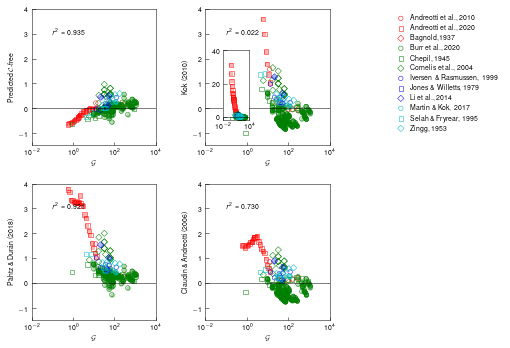

In [51]:
fig = plt.gcf()

S = 20
lw = 0.5
Alpha = 0.3

ax0 = plt.subplot(231)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax0.scatter(Ga_opp[temp],us_opp[temp]/us_opp_pred[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax0.scatter(Ga_opp[temp],us_opp[temp]/us_opp_pred[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax0.text(1e-1,3,'$r^2 = %.3f$'%r_fitted**2.,fontsize=fs)
ax0.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax0.set_xscale('log')
ax0.set_xlim(1e-2,1e+4)
ax0.set_ylim(-1.5,4)
ax0.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax0.set_ylabel('Predicted $\\mathcal{C}$-free',fontsize=fs)
ax0.set_yticks([-1,0,1,2,3,4])
ax0.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax0.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax0.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax1 = plt.subplot(232)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax1.scatter(Ga_opp[temp],us_opp[temp]/us_opp_kok[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax1.scatter(Ga_opp[temp],us_opp[temp]/us_opp_kok[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax1.text(1e-1,3,'$r^2 = %.3f$'%r_kok**2.,fontsize=fs)
ax1.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax1.set_xscale('log')
ax1.set_xlim(1e-2,1e+4)
ax1.set_ylim(-1.5,4)
ax1.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax1.set_ylabel('Kok (2010)',fontsize=fs)
ax1.set_yticks([-1,0,1,2,3,4])
ax1.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax1.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax1.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax11 = fig.add_axes([0.44,0.66,0.05,0.2])

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax11.scatter(Ga_opp[temp],us_opp[temp]/us_opp_kok[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax11.scatter(Ga_opp[temp],us_opp[temp]/us_opp_kok[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax11.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax11.set_xscale('log')
ax11.set_xlim(1e-2,1e+4)
ax11.set_ylim(-1.5,40)
ax11.set_yticks([0,20,40])
ax11.set_yticklabels(['$0$','$20$','$40$'],fontsize=fs)
ax11.set_xticks([1e-2,1e+4])
ax11.set_xticklabels(['$10^{-2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax2 = plt.subplot(234)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax2.scatter(Ga_opp[temp],us_opp[temp]/us_opp_pahtz[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax2.scatter(Ga_opp[temp],us_opp[temp]/us_opp_pahtz[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j])
ax2.text(1e-1,3,'$r^2 = %.3f$'%r_pahtz**2.,fontsize=fs)
ax2.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax2.set_xscale('log')
ax2.set_xlim(1e-2,1e+4)
ax2.set_ylim(-1.5,4)
ax2.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax2.set_ylabel('Pähtz \& Durán (2018)',fontsize=fs)
ax2.set_yticks([-1,0,1,2,3,4])
ax2.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax2.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax2.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()

ax3 = plt.subplot(235)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            if uniquerefs[i*len(markers)+j] in ofnoterefs:
                ax3.scatter(Ga_opp[temp],us_opp[temp]/us_opp_claudin[temp]-1,s=S,color=colors[i],alpha=Alpha,lw=0,edgecolor=colors[i],marker=markers[j])
            ax3.scatter(Ga_opp[temp],us_opp[temp]/us_opp_claudin[temp]-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j],label=uniquerefs[i*len(markers)+j])
ax3.text(1e-1,3,'$r^2 = %.3f$'%r_claudin**2.,fontsize=fs)
ax3.plot([1e-2,1e+4],[0,0],'k',lw=lw)
ax3.set_xscale('log')
ax3.set_xlim(1e-2,1e+4)
ax3.set_ylim(-1.5,4)
ax3.set_xlabel('$\\mathcal{G}$',fontsize=fs)
ax3.set_ylabel('Claudin \& Andreotti (2006)',fontsize=fs)
ax3.set_yticks([-1,0,1,2,3,4])
ax3.set_yticklabels(['$-1$','$0$','$1$','$2$','$3$','$4$'],fontsize=fs)
ax3.set_xticks([1e-2,1e+0,1e+2,1e+4])
ax3.set_xticklabels(['$10^{-2}$','$10^{0}$','$10^{2}$','$10^{4}$'],fontsize=fs)
plt.minorticks_off()


ax4 = plt.subplot(233)

for i in range(len(colors)):
    for j in range(len(markers)):
        if i*len(markers)+j<len(uniquerefs):
            temp = np.argwhere(ref_opp==uniquerefs[i*len(markers)+j])
            ax4.scatter(us_opp[temp]*-1,us_opp_claudin[temp]*-1,s=S,color='none',edgecolor=colors[i],lw=lw,marker=markers[j],label=uniquerefsfull[i*len(markers)+j])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(1e-2,1e+1)
ax4.set_ylim(1e-2,1e+1)
ax4.axis('off')
ax4.legend(frameon=False,fontsize=fs,handlelength=lw*2,ncol=1)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax11.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax11.spines[axis].set_linewidth(lw) 
    
fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.28)
fig.subplots_adjust(bottom=0.08)
fig.subplots_adjust(top=0.98)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig4-rough.pdf', dpi=300)

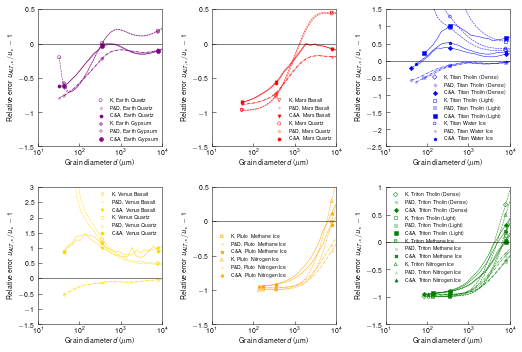

In [54]:
fig = plt.gcf()

S = 10
lw = 0.5
Alpha = 0.3

i = 0
ax0 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax0.plot(dtemp[1:]*1e+6,tempkok[1:]/tempustemp[1:]-1,c=color[i],linestyle='--',lw=lw)
    ax0.scatter(dtemp[1]*1e+6,tempkok[1]/tempustemp[1]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax0.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax0.plot(dtemp[1:]*1e+6,temppahtz[1:]/tempustemp[1:]-1,c=color[i],linestyle='-.',lw=lw)
    ax0.scatter(dtemp[1]*1e+6,temppahtz[1]/tempustemp[1]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax0.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax0.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    
    ax0.plot(dtemp[1:]*1e+6,tempclaudin[1:]/tempustemp[1:]-1,c=color[i],linestyle='-',lw=lw)
    ax0.scatter(dtemp[1]*1e+6,tempclaudin[1]/tempustemp[1]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax0.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax0.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    
ax0.plot(d*1e+6,0*d,'k',lw=lw)
ax0.set_xscale('log')
ax0.set_xlim(1e+1,1e+4)
ax0.set_ylim(-1.5,0.5)
ax0.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax0.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax0.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax0.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax0.set_yticks([-1.5,-1,-0.5,0,0.5])
ax0.set_yticklabels(['$-1.5$','$-1$','$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75)

i = 1
ax1 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax1.plot(dtemp[0:]*1e+6,tempkok[0:]/tempustemp[0:]-1,c=color[i],linestyle='--',lw=lw)
    ax1.scatter(dtemp[0]*1e+6,tempkok[0]/tempustemp[0]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax1.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax1.plot(dtemp[0:]*1e+6,temppahtz[0:]/tempustemp[0:]-1,c=color[i],linestyle='-.',lw=lw)
    ax1.scatter(dtemp[0]*1e+6,temppahtz[0]/tempustemp[0]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax1.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax1.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    
    ax1.plot(dtemp[0:]*1e+6,tempclaudin[0:]/tempustemp[0:]-1,c=color[i],linestyle='-',lw=lw)
    ax1.scatter(dtemp[0]*1e+6,tempclaudin[0]/tempustemp[0]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax1.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax1.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    
ax1.plot(d*1e+6,0*d,'k',lw=lw)
ax1.set_xscale('log')
ax1.set_xlim(1e+1,1e+4)
ax1.set_ylim(-1.5,0.5)
ax1.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax1.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax1.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax1.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax1.set_yticks([-1.5,-1,-0.5,0,0.5])
ax1.set_yticklabels(['$-1.5$','$-1$','$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75)

i = 2
ax2 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax2.plot(dtemp[0:]*1e+6,tempkok[0:]/tempustemp[0:]-1,c=color[i],linestyle='--',lw=lw)
    ax2.scatter(dtemp[0]*1e+6,tempkok[0]/tempustemp[0]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax2.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax2.plot(dtemp[0:]*1e+6,temppahtz[0:]/tempustemp[0:]-1,c=color[i],linestyle='-.',lw=lw)
    ax2.scatter(dtemp[0]*1e+6,temppahtz[0]/tempustemp[0]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax2.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax2.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    
    ax2.plot(dtemp[0:]*1e+6,tempclaudin[0:]/tempustemp[0:]-1,c=color[i],linestyle='-',lw=lw)
    ax2.scatter(dtemp[0]*1e+6,tempclaudin[0]/tempustemp[0]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax2.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax2.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    
ax2.plot(d*1e+6,0*d,'k',lw=lw)
ax2.set_xscale('log')
ax2.set_xlim(1e+1,1e+4)
ax2.set_ylim(-2.5,1.5)
ax2.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax2.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax2.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax2.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax2.set_yticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5])
ax2.set_yticklabels(['$-2.5$','$-2$','$-1.5$','$-1$','$-0.5$','$0$','$0.5$','$1$','$1.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75,loc=4)

i = 3
ax3 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax3.plot(dtemp[0:]*1e+6,tempkok[0:]/tempustemp[0:]-1,c=color[i],linestyle='--',lw=lw)
    ax3.scatter(dtemp[0]*1e+6,tempkok[0]/tempustemp[0]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax3.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax3.plot(dtemp[0:]*1e+6,temppahtz[0:]/tempustemp[0:]-1,c=color[i],linestyle='-.',lw=lw)
    ax3.scatter(dtemp[0]*1e+6,temppahtz[0]/tempustemp[0]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax3.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax3.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    
    ax3.plot(dtemp[0:]*1e+6,tempclaudin[0:]/tempustemp[0:]-1,c=color[i],linestyle='-',lw=lw)
    ax3.scatter(dtemp[0]*1e+6,tempclaudin[0]/tempustemp[0]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax3.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax3.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    
ax3.plot(d*1e+6,0*d,'k',lw=lw)
ax3.set_xscale('log')
ax3.set_xlim(1e+1,1e+4)
ax3.set_ylim(-1.5,2)
ax3.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax3.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax3.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax3.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax3.set_yticks([-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
ax3.set_yticklabels(['$-1.5$','$-1$','$-0.5$','$0$','$0.5$','$1$','$1.5$','$2$','$2.5$','$3$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75)

i = 4
ax4 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax4.plot(dtemp[0:]*1e+6,tempkok[0:]/tempustemp[0:]-1,c=color[i],linestyle='--',lw=lw)
    ax4.scatter(dtemp[0]*1e+6,tempkok[0]/tempustemp[0]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax4.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax4.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax4.plot(dtemp[0:]*1e+6,temppahtz[0:]/tempustemp[0:]-1,c=color[i],linestyle='-.',lw=lw)
    ax4.scatter(dtemp[0]*1e+6,temppahtz[0]/tempustemp[0]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax4.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax4.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])

    ax4.plot(dtemp[0:]*1e+6,tempclaudin[0:]/tempustemp[0:]-1,c=color[i],linestyle='-',lw=lw)
    ax4.scatter(dtemp[0]*1e+6,tempclaudin[0]/tempustemp[0]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax4.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax4.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])

ax4.plot(d*1e+6,0*d,'k',lw=lw)
ax4.set_xscale('log')
ax4.set_xlim(1e+1,1e+4)
ax4.set_ylim(-1.5,0.5)
ax4.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax4.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax4.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax4.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax4.set_yticks([-1.5,-1,-0.5,0,0.5])
ax4.set_yticklabels(['$-1.5$','$-1$','$-0.5$','$0$','$0.5$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75)

i = 5
ax5 = plt.subplot(2,3,i+1)
    
for j in range(len(sediment[i])):
    
    tempus = np.mean(np.mean(us_flagged[i][j],axis=0),axis=0)

    dtemp = np.delete(d,np.argwhere(np.isnan(tempus)))
    tempustemp = np.delete(tempus,np.argwhere(np.isnan(tempus)))
    tempkok = np.delete(us_kok[i][j],np.argwhere(np.isnan(tempus)))
    temppahtz = np.delete(us_pahtz[i][j],np.argwhere(np.isnan(tempus)))
    tempclaudin = np.delete(us_claudin[i][j],np.argwhere(np.isnan(tempus)))

    ax5.plot(dtemp[0:]*1e+6,tempkok[0:]/tempustemp[0:]-1,c=color[i],linestyle='--',lw=lw)
    ax5.scatter(dtemp[0]*1e+6,tempkok[0]/tempustemp[0]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j],label='K, %s %s'%(name[i],sediment[i][j]))
    ax5.scatter(dtemp[-2]*1e+6,tempkok[-2]/tempustemp[-2]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])
    ax5.scatter(dtemp[-int(Nd/2)]*1e+6,tempkok[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,facecolor='none',edgecolor=color[i],lw=lw,marker=marker[i][j])

    ax5.plot(dtemp[0:]*1e+6,temppahtz[0:]/tempustemp[0:]-1,c=color[i],linestyle='-.',lw=lw)
    ax5.scatter(dtemp[0]*1e+6,temppahtz[0]/tempustemp[0]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j],label='P\&D, %s %s'%(name[i],sediment[i][j]))
    ax5.scatter(dtemp[-2]*1e+6,temppahtz[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])
    ax5.scatter(dtemp[-int(Nd/2)]*1e+6,temppahtz[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=0,alpha=Alpha,marker=marker[i][j])

    ax5.plot(dtemp[0:]*1e+6,tempclaudin[0:]/tempustemp[0:]-1,c=color[i],linestyle='-',lw=lw)
    ax5.scatter(dtemp[0]*1e+6,tempclaudin[0]/tempustemp[0]-1,s=S,c=color[i],lw=lw,marker=marker[i][j],label='C\&A, %s %s'%(name[i],sediment[i][j]))
    ax5.scatter(dtemp[-2]*1e+6,tempclaudin[-2]/tempustemp[-2]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])
    ax5.scatter(dtemp[-int(Nd/2)]*1e+6,tempclaudin[-int(Nd/2)]/tempustemp[-int(Nd/2)]-1,s=S,c=color[i],lw=lw,marker=marker[i][j])

ax5.plot(d*1e+6,0*d,'k',lw=lw)
ax5.set_xscale('log')
ax5.set_xlim(1e+1,1e+4)
ax5.set_ylim(-1.5,1)
ax5.set_xlabel('Grain diameter $d$ ($\\mu$m)',fontsize=fs)
ax5.set_ylabel('Relative error $u_{ALT,*}/u_{*}-1$',fontsize=fs)
ax5.set_xticks([1e+1,1e+2,1e+3,1e+4])
ax5.set_xticklabels(['$10^{1}$','$10^{2}$','$10^{3}$','$10^{4}$'],fontsize=fs)
ax5.set_yticks([-1.5,-1,-0.5,0,0.5,1])
ax5.set_yticklabels(['$-1.5$','$-1$','$-0.5$','$0$','$0.5$','$1$'],fontsize=fs)
plt.minorticks_off()
plt.legend(frameon=False,fontsize=fs*0.75)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw)
    
fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(bottom=0.07)
fig.subplots_adjust(top=0.98)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(left=0.07)

fig.set_size_inches(183./25.4, 183./1.5/25.4, forward=True)
# plt.savefig('exfig5-rough.pdf', dpi=300)